## Funnel Metadynamics simulations -  Analysis

### Funnel Metadynamics

* A binding free energy method that explores the ligand binding process from its solvated state to the final binding site.

* The exploration of the space of the selected degrees of freedom (Collective Variables, CVs) is enhanced by applying a bias potential constructed as a sum of Gaussian functions.

* The method gives an accurate calculation of the absolute protein-ligand binding energy.

* It allows the identification of the ligand binding mode and potentially alternative binding modes.

* Finally, it provides an insight into the dynamics of ligand binding mechanism.

### Import packages

Required packages are imported


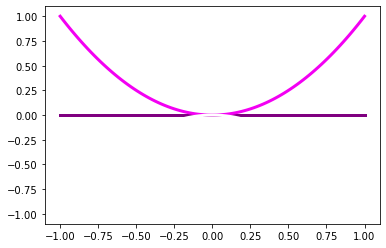

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
from scipy.interpolate import griddata
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import sys
import MDAnalysis as mda
import math
from numpy.linalg import norm
from color_lightness import adjust_lightness
print("Required packages are imported")

### Define colours

Color dictionaries: 
* col1 - Wes Anderson
* col2 - colorbrewer colorblind-safe

In [2]:
col1 = {'red': (0.58, 0.29, 0.31), 'yellow': (0.76, 0.56, 0.00), 'blue': (0.38, 0.54, 0.60), 'green': (0.43, 0.60, 0.48)}
col2 = {'red': '#e66101' , 'orange': '#fdb863', 'lavender': '#b2abd2', 'purple': '#5e3c99'}
print("Colour dictionaries are defined")

Colour dictionaries are defined


### Define the path of the simulation files required for the analysis

In [3]:
path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ATTEMPT7"
print(path)
%cd {path}

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ATTEMPT7
/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ATTEMPT7


### Compute Free Energy Profiles from HILLS file

* Execute a home-made bash script (analysis.sh) that uses the sum_hills tool from PLUMED to read the HILLS file and calculate the free energy profile.

* The analyze-FES.sh script will aslo be executed, which computes the absolute binding free energy, as the difference between the bound and unbound states.

In [4]:
#Go to the directory of the run
%cd {path}/HILLS

#Remove previously generated energy files
%rm fes*

#Execute energy script
!bash analysis.sh -f 20

"""
Usage: !bash analysis.sh [options]

The following options are required:

-r - The ID of the simulation repeat
-s - The stride that will be used by sum_hills to integrate the HILLS file and compute the free energy profile at different points during the simulation
-f - Frequency of FE computation [in ns]; Compute FE profile every f ns. 

Note: Make sure to select a stride that will compute the FE profile every 50 ns. 
      HILLS saves every 2 ps, ie, 50 ns = 50000 ps => stride = 25000.
"""

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ATTEMPT7/HILLS
zsh:1: no matches found: fes*
1
2
3
{303354 HILLS}
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.2 (git: Unknown) compiled on Oct 15 2021 at 15:16:33
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /biggin/b134/bioc1550/opt/plumed/lib/plumed
PLUMED: For installed feature, see /biggin/b134/bioc1550/opt/plumed/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camillo

PLUMED:   done with this chunk: now with 40000 kernels  
PLUMED: 
PLUMED:   Bias: Projecting on subgrid... 
PLUMED:   Bias: Writing subgrid on file fes_3.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 50000 kernels  
PLUMED: 
PLUMED:   Bias: Projecting on subgrid... 
PLUMED:   Bias: Writing subgrid on file fes_4.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 60000 kernels  
PLUMED: 
PLUMED:   Bias: Projecting on subgrid... 
PLUMED:   Bias: Writing subgrid on file fes_5.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 70000 kernels  
PLUMED: 
PLUMED:   Bias: Projecting on subgrid... 
PLUMED:   Bias: Writing subgrid on file fes_6.dat 
PLUMED:   reading hills: 
PLUMED:   doing serialread 
PLUMED:   done with this chunk: now with 80000 kernels  
PLUMED: 
PLUMED:   Bias: Projecting on subgrid... 
PLUMED:   Bias: Writing subgrid on file 

'\nUsage: !bash analysis.sh [options]\n\nThe following options are required:\n\n-r - The ID of the simulation repeat\n-s - The stride that will be used by sum_hills to integrate the HILLS file and compute the free energy profile at different points during the simulation\n-f - Frequency of FE computation [in ns]; Compute FE profile every f ns. \n\nNote: Make sure to select a stride that will compute the FE profile every 50 ns. \n      HILLS saves every 2 ps, ie, 50 ns = 50000 ps => stride = 25000.\n'

### CV space sampling with time

Plot of the ligand CoM position along the funnel axis, p (CV1) as a function of the simulation time. The yellow region denotes the bound state. 

<IPython.core.display.Javascript object>


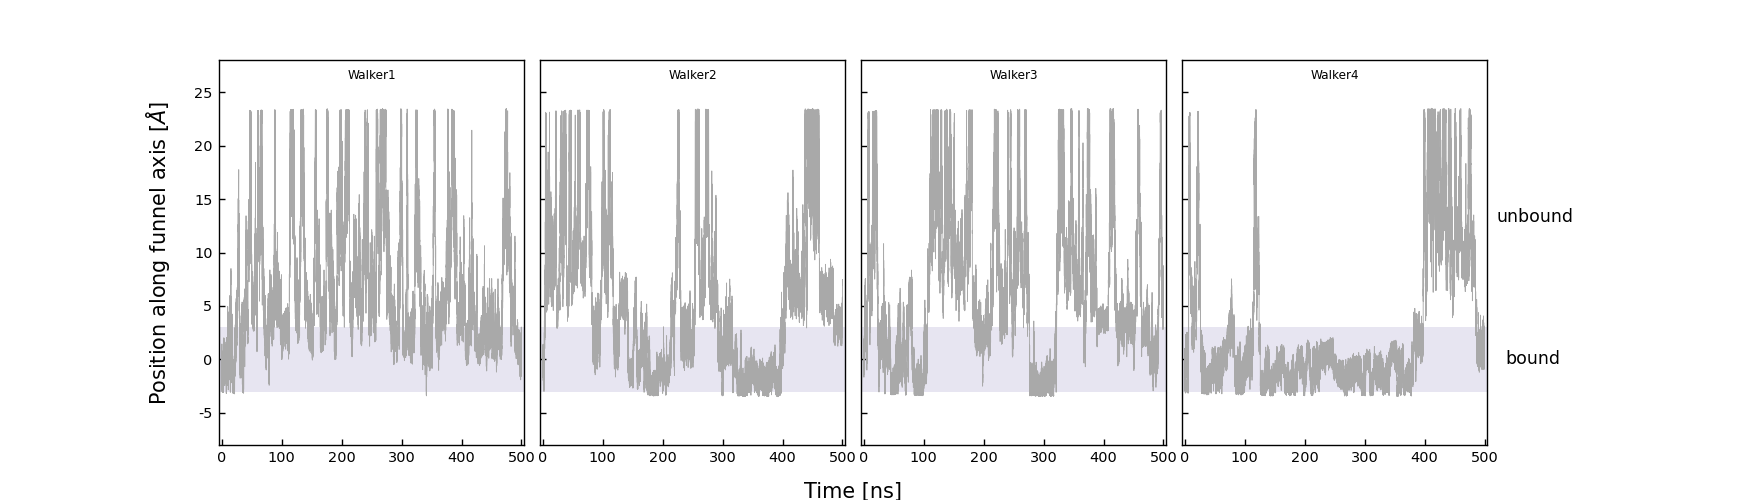

In [22]:
%matplotlib notebook

#########################################################################################
#Compute the ligand position along the sunnel axis (CV1) as a function of simulation time
#########################################################################################

#Introduce the dictionaries that will store the CVs.
d_Time={}
d_lp={}
#Give the number of multiple walkers
n_walkers=4

#Define path of simulation data  
for run in range(1, n_walkers+1):
    #Monitor calculation progress
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 1]*10
    

##################################################################################################

##########################################################################################
#Plot the CV1 space that has been sampled during the Funnel MetaD simulation in one figure
##########################################################################################

fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 4))

step=10

#Read the data to find the lower and upper limits of the x-axis
xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{1}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{1}"])))
xstep=100


for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_Time[f"Time{i+1}"])[::step], np.array(d_lp[f"lp{i+1}"])[::step], linewidth=0.5, color='darkgray')
    ax.set_xlim([xmin-5, xmax+5])
#     ax.set_xticks(np.arange(int(xmin), int(xmax), xstep))
#     ax.set_xticklabels(np.arange(int(xmin), int(xmax), xstep), fontsize='small')
    ax.set_xticks(np.arange(0, 501, xstep))
    ax.set_xticklabels(np.arange(0, 501, xstep), fontsize='small')
    ax.set_ylim([-8, 28])
    ax.set_yticks([-5, 0, 5, 10, 15, 20, 25])
    ax.set_yticklabels([-5, 0, 5, 10, 15, 20, 25], fontsize='small')
    ax.text(0.5, 0.95, f"Walker{i+1}", ha='center', transform=ax.transAxes, fontsize='x-small')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.axhspan(-3.0, 3.0, facecolor=col2['lavender'], alpha=0.3)

fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('Position along funnel axis [$\AA$]', fontsize='large')
plt.text(1.28, 0.58, "unbound", ha='right', transform=ax.transAxes)
plt.text(1.24, 0.21, "bound", ha='right', transform=ax.transAxes)



#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(right=0.85, wspace=0.05, hspace=0.0)


#Save figure in the ANALYSIS directory as a .png image
plt.savefig(f"{path}/ANALYSIS/position_all.png", bbox_inches='tight', dpi=600)

plt.show()

### Binding Events

A ligand binding event is considered to occur when ligand positional criteria are satisfied. In particular, based on the FES figure, the free energy well that corresponds to the binding pocket can be described by the values of the two CVs, lp and ld. When the ligand CoM is within both the limits of the CVs that correspond to the limits of the binding pocket, a binding event is registered. 

In [33]:
%matplotlib notebook

##################################################################
#Compute the ligand binding events as a function of simulation time
##################################################################

#Define the positional criteria that describe a binding event of the ligand at the known binding pocket
lowerlimitlp, upperlimitlp=-3.0, 3.0
lowerlimitld, upperlimitld=0.0, 4.0

#Introduce the dictionaries that will store the CVs.
d_Time={}
d_lp={}
d_ld={}
d_data={}
n_walkers=5

#Define path of simulation data  
for run in range(1, n_walkers+1):
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ATTEMPT6/{run}"
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/COLVAR", comments="#")[:, 1]*10
    d_ld[f"ld{run}"]=np.loadtxt(f"{path}/COLVAR", comments="#")[:, 2]*10
    
    
    #Compute the ligand binding events as a function of time and save in data dictionary
    bind=[]
    for x, y, z in zip(d_lp[f"lp{run}"], d_ld[f"ld{run}"], d_Time[f"Time{run}"]):
    # print(x, y, z)
        if lowerlimitlp<=x<=upperlimitlp and lowerlimitld<=y<=upperlimitld:
            bind.append((True)) 
#             print(z, True)
        else:
            bind.append((False))
#             print(z, False)  

    data_old=np.full(len(d_Time[f"Time{run}"]), bind, dtype=bool)
    d_data[f"data{run}"]=np.reshape(data_old, (-1, len(d_Time[f"Time{run}"])))
    
###################################################################################################################

##########################################################
#Plot the binding events for all the walkers in one figure
##########################################################

#Give number of rows and columns for the figure and figure size
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 4))

#Define colormap, step and legend properties
cmap=plt.cm.Purples
#cmap=plt.cm.Reds
step=1
props = dict(facecolor=adjust_lightness('purple', 3.95))

#Read the data to find the lower and upper limits of the x-axis
xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{1}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{1}"])))
xstep=20
print(xmin, xmax)
#Loop over the data for each walker and plot in a subplot
for i, ax in enumerate(fig.axes):
    image=ax.imshow(np.array(d_data[f"data{i+1}"]), aspect='auto', interpolation=None, cmap=cmap)
    ax.set_xticks(np.arange(xmin*1000, (xmax*1000)+1, xstep*1000))
    ax.set_xticklabels(np.arange(int(xmin), int(xmax)+1, xstep), fontsize='small')
    ax.set_xlim(xmin*1000, xmax*1000)
    ax.tick_params(axis='x', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.tick_params(axis='y', left=False, right=False, which='major', labelbottom=True, labeltop=False, labelleft=False, labelright=False, direction='in')
    ax.text(0.95, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='right', bbox=props, fontsize='x-small')

#Add common x- and y- axes for all the subplots  
fig.add_subplot(111, frameon=False)
#Hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('Binding Events', fontsize='large')

#Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#Define the space between subplots and the space from the borders
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
#fig.tight_layout()

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/bind_bool_all.png", bbox_inches='tight', dpi=600)


#Show figure in Jupyter Notebook
plt.show()

Walker:  0
0.0 True
0.0002 True
0.0004 True
0.0006 True
0.0008 True
0.001 True
0.0012 True
0.0014 True
0.0016 True
0.0018 True
0.002 True
0.0022 True
0.0024 True
0.0026 True
0.0028 True
0.003 True
0.0032 True
0.0034 True
0.0036 True
0.0038 True
0.004 True
0.004200000000000001 True
0.0044 True
0.0046 True
0.0048 True
0.005 True
0.0052 True
0.0054 True
0.0056 True
0.0058 True
0.006 True
0.0062 True
0.0064 True
0.0066 True
0.0068 True
0.007 True
0.0072 True
0.0074 True
0.0076 True
0.0078 True
0.008 True
0.008199999999999999 True
0.008400000000000001 True
0.0086 True
0.0088 True
0.009 True
0.0092 True
0.0094 True
0.0096 True
0.009800000000000001 True
0.01 True
0.010199999999999999 True
0.0104 True
0.0106 True
0.0108 True
0.011 True
0.0112 True
0.0114 True
0.0116 True
0.011800000000000001 True
0.012 True
0.012199999999999999 True
0.0124 True
0.0126 True
0.0128 True
0.013 True
0.0132 True
0.0134 True
0.0136 True
0.013800000000000002 True
0.014 True
0.014199999999999999 True
0.0144 True
0.014

0.293 True
0.2932 True
0.2934 True
0.2936 True
0.2938 True
0.294 True
0.29419999999999996 True
0.2944 True
0.29460000000000003 True
0.2948 True
0.295 True
0.29519999999999996 True
0.2954 True
0.29560000000000003 True
0.2958 True
0.296 True
0.29619999999999996 True
0.2964 True
0.29660000000000003 True
0.2968 True
0.297 True
0.29719999999999996 True
0.2974 True
0.29760000000000003 True
0.2978 True
0.298 True
0.29819999999999997 True
0.2984 True
0.29860000000000003 True
0.2988 True
0.299 True
0.29919999999999997 True
0.2994 True
0.29960000000000003 True
0.2998 True
0.3 True
0.30019999999999997 True
0.3004 True
0.30060000000000003 True
0.3008 True
0.301 True
0.30119999999999997 True
0.3014 True
0.30160000000000003 True
0.3018 True
0.302 True
0.30219999999999997 True
0.3024 True
0.30260000000000004 True
0.3028 True
0.303 True
0.30319999999999997 True
0.3034 True
0.30360000000000004 True
0.3038 True
0.304 True
0.30419999999999997 True
0.3044 True
0.30460000000000004 True
0.3048 True
0.305 Tr

0.6292000000000001 True
0.6294 True
0.6296 True
0.6297999999999999 True
0.63 True
0.6302000000000001 True
0.6304 True
0.6306 True
0.6307999999999999 True
0.631 True
0.6312000000000001 True
0.6314 True
0.6316 True
0.6317999999999999 True
0.632 True
0.6322000000000001 True
0.6324 True
0.6326 True
0.6327999999999999 True
0.633 True
0.6332000000000001 True
0.6334 True
0.6336 True
0.6337999999999999 True
0.634 True
0.6342000000000001 True
0.6344 True
0.6346 True
0.6347999999999999 True
0.635 True
0.6352000000000001 True
0.6354 True
0.6356 True
0.6357999999999999 True
0.636 True
0.6362000000000001 True
0.6364 True
0.6366 True
0.6367999999999999 True
0.637 True
0.6372000000000001 True
0.6374 True
0.6376000000000001 True
0.6377999999999999 True
0.638 True
0.6382000000000001 True
0.6384 True
0.6386000000000001 True
0.6387999999999999 True
0.639 True
0.6392 True
0.6394 True
0.6396000000000001 True
0.6397999999999999 True
0.64 True
0.6402 True
0.6404 True
0.6406000000000001 True
0.640799999999999

1.018 True
1.0182 True
1.0184 True
1.0186 True
1.0188 True
1.019 True
1.0192 True
1.0194 True
1.0196 True
1.0198 True
1.02 True
1.0202 True
1.0204 True
1.0206 True
1.0208 True
1.021 True
1.0212 True
1.0214 True
1.0216 True
1.0218 True
1.022 True
1.0222 True
1.0224 True
1.0226 True
1.0228 True
1.023 True
1.0232 True
1.0234 True
1.0236 True
1.0238 True
1.024 True
1.0242 True
1.0244000000000002 True
1.0246 True
1.0248 True
1.025 True
1.0252000000000001 True
1.0254 True
1.0255999999999998 True
1.0258 True
1.026 True
1.0262 True
1.0264000000000002 True
1.0266 True
1.0268 True
1.027 True
1.0272000000000001 True
1.0274 True
1.0275999999999998 True
1.0278 True
1.028 True
1.0282 True
1.0284 True
1.0286 True
1.0288 True
1.029 True
1.0292000000000001 True
1.0294 True
1.0295999999999998 True
1.0298 True
1.03 True
1.0302 True
1.0304 True
1.0306 True
1.0308 True
1.031 True
1.0312000000000001 True
1.0314 True
1.0315999999999999 True
1.0318 True
1.032 True
1.0322 True
1.0324 True
1.0326 True
1.0328 Tr

1.3406 True
1.3408 True
1.341 True
1.3412 True
1.3414000000000001 True
1.3416 True
1.3417999999999999 True
1.342 True
1.3422 False
1.3424 True
1.3426 True
1.3428 True
1.343 True
1.3432 True
1.3434000000000001 True
1.3436 True
1.3437999999999999 True
1.344 True
1.3442 False
1.3444 False
1.3446 False
1.3448 False
1.345 False
1.3452 True
1.3454000000000002 False
1.3456 False
1.3457999999999999 True
1.346 True
1.3462 True
1.3464 False
1.3466 True
1.3468 True
1.347 True
1.3472 False
1.3474000000000002 True
1.3476 True
1.3477999999999999 True
1.348 False
1.3482 False
1.3484 False
1.3485999999999998 True
1.3488 True
1.349 True
1.3492 False
1.3494000000000002 True
1.3496 True
1.3497999999999999 True
1.35 True
1.3502 True
1.3504 True
1.3505999999999998 True
1.3508 True
1.351 True
1.3512 True
1.3514000000000002 True
1.3516 True
1.3518 True
1.352 True
1.3522 True
1.3524 True
1.3525999999999998 True
1.3528 True
1.353 True
1.3532 True
1.3534000000000002 True
1.3536 True
1.3538 True
1.354 True
1.354

1.6716 True
1.6718 True
1.672 True
1.6722000000000001 True
1.6724 True
1.6725999999999999 True
1.6728 True
1.673 True
1.6732 True
1.6734 True
1.6736 True
1.6738 True
1.674 True
1.6742000000000001 True
1.6744 True
1.6745999999999999 True
1.6747999999999998 True
1.675 True
1.6752 True
1.6754 True
1.6756 True
1.6758 True
1.676 True
1.6762000000000001 True
1.6764000000000001 True
1.6765999999999999 True
1.6767999999999998 True
1.677 True
1.6772 True
1.6774 True
1.6776 True
1.6778 True
1.678 True
1.6782000000000001 True
1.6784000000000001 True
1.6785999999999999 True
1.6787999999999998 True
1.679 True
1.6792 True
1.6794 True
1.6796 True
1.6798 True
1.68 True
1.6802000000000001 True
1.6804000000000001 True
1.6805999999999999 True
1.6807999999999998 True
1.681 True
1.6812 True
1.6814 True
1.6816 True
1.6818 True
1.682 True
1.6822000000000001 True
1.6824000000000001 True
1.6825999999999999 True
1.6827999999999999 True
1.683 True
1.6832 True
1.6834 True
1.6836 True
1.6838 True
1.684 True
1.6842

2.0122 True
2.0124 True
2.0126 True
2.0128 True
2.013 True
2.0132 True
2.0134000000000003 True
2.0136 True
2.0138 True
2.014 True
2.0142 True
2.0144 True
2.0145999999999997 True
2.0148 True
2.015 True
2.0152 True
2.0154 True
2.0156 True
2.0158 True
2.016 True
2.0162 True
2.0164 True
2.0166 True
2.0168 True
2.017 True
2.0172 True
2.0174000000000003 True
2.0176 True
2.0178 True
2.018 True
2.0182 True
2.0184 True
2.0185999999999997 True
2.0188 True
2.019 True
2.0192 True
2.0194 True
2.0196 True
2.0198 True
2.02 True
2.0202 True
2.0204 True
2.0206 True
2.0208 True
2.021 True
2.0212 True
2.0214000000000003 True
2.0216 True
2.0218 True
2.022 True
2.0222 True
2.0224 True
2.0225999999999997 True
2.0228 True
2.023 True
2.0232 True
2.0234 True
2.0236 True
2.0238 True
2.024 True
2.0242 True
2.0244 True
2.0246 True
2.0248 True
2.025 True
2.0252 True
2.0254000000000003 True
2.0256 True
2.0258 True
2.026 True
2.0262000000000002 True
2.0264 True
2.0265999999999997 True
2.0268 True
2.027 True
2.0272 T

2.3581999999999996 False
2.3584 True
2.3586 True
2.3588 True
2.359 True
2.3592 True
2.3594 True
2.3596 True
2.3598000000000003 True
2.36 True
2.3602 True
2.3604000000000003 True
2.3606 True
2.3608000000000002 True
2.361 True
2.3611999999999997 True
2.3614 True
2.3615999999999997 True
2.3618 True
2.362 True
2.3621999999999996 True
2.3624 True
2.3626 True
2.3628 True
2.363 True
2.3632 True
2.3634 True
2.3636 True
2.3638000000000003 True
2.364 True
2.3642 True
2.3644000000000003 True
2.3646 True
2.3648000000000002 True
2.365 True
2.3651999999999997 True
2.3654 True
2.3655999999999997 True
2.3658 True
2.366 True
2.3661999999999996 True
2.3664 True
2.3666 True
2.3668 True
2.367 True
2.3672 True
2.3674 True
2.3676 True
2.3678000000000003 True
2.368 True
2.3682 True
2.3684000000000003 True
2.3686 True
2.3688000000000002 True
2.369 True
2.3691999999999998 True
2.3694 True
2.3695999999999997 True
2.3698 True
2.37 True
2.3701999999999996 True
2.3704 True
2.3706 True
2.3708 True
2.371 True
2.3712

2.7404 False
2.7405999999999997 False
2.7408 True
2.741 False
2.7411999999999996 False
2.7414 False
2.7416 False
2.7418 False
2.742 False
2.7422 True
2.7424 False
2.7426 False
2.7428000000000003 False
2.743 False
2.7432 False
2.7434000000000003 False
2.7436 False
2.7438000000000002 False
2.744 False
2.7441999999999998 False
2.7444 False
2.7445999999999997 False
2.7448 True
2.745 False
2.7451999999999996 True
2.7454 False
2.7456 False
2.7458 True
2.746 False
2.7462 True
2.7464 False
2.7466 False
2.7468000000000004 False
2.747 False
2.7472 False
2.7474000000000003 False
2.7476 False
2.7478000000000002 False
2.748 False
2.7481999999999998 False
2.7484 False
2.7485999999999997 False
2.7488 True
2.749 True
2.7491999999999996 True
2.7494 True
2.7496 False
2.7498 False
2.75 False
2.7502 True
2.7504 False
2.7506 False
2.7508000000000004 False
2.751 False
2.7512 False
2.7514000000000003 False
2.7516 False
2.7518000000000002 False
2.752 False
2.7521999999999998 True
2.7524 False
2.75259999999999

3.0951999999999997 False
3.0954 False
3.0956 False
3.0958 False
3.096 False
3.0961999999999996 False
3.0964 False
3.0966 False
3.0968 False
3.097 False
3.0972 False
3.0974 False
3.0976 False
3.0978000000000003 False
3.098 False
3.0982 False
3.0984000000000003 False
3.0986 False
3.0988 False
3.099 False
3.0991999999999997 False
3.0994 False
3.0995999999999997 False
3.0998 False
3.1 False
3.1001999999999996 False
3.1004 False
3.1006 False
3.1008 False
3.101 False
3.1012 False
3.1014 False
3.1016 False
3.1018000000000003 False
3.102 False
3.1022 False
3.1024000000000003 False
3.1026 False
3.1028000000000002 False
3.103 False
3.1031999999999997 False
3.1034 False
3.1035999999999997 False
3.1038 False
3.104 False
3.1041999999999996 False
3.1044 False
3.1046 False
3.1048 False
3.105 False
3.1052 False
3.1054 False
3.1056 False
3.1058000000000003 False
3.106 False
3.1062 False
3.1064000000000003 False
3.1066 False
3.1068000000000002 False
3.107 False
3.1071999999999997 False
3.1074 False
3.10

3.4664 False
3.4666 False
3.4668 False
3.467 False
3.4671999999999996 False
3.4674 False
3.4676 False
3.4678 False
3.468 False
3.4682 False
3.4684 False
3.4686 False
3.4688000000000003 False
3.469 False
3.4692 False
3.4694000000000003 False
3.4696 False
3.4698 False
3.47 False
3.4701999999999997 False
3.4704 False
3.4706 False
3.4708 False
3.471 False
3.4711999999999996 False
3.4714 False
3.4716 False
3.4718 False
3.472 False
3.4722 False
3.4724 False
3.4726 False
3.4728000000000003 False
3.473 False
3.4732 False
3.4734000000000003 False
3.4736 False
3.4738 False
3.474 False
3.4741999999999997 False
3.4744 False
3.4745999999999997 False
3.4748 False
3.475 False
3.4751999999999996 False
3.4754 False
3.4756 False
3.4758 False
3.476 False
3.4762 False
3.4764 False
3.4766 False
3.4768000000000003 False
3.477 False
3.4772 False
3.4774000000000003 False
3.4776 False
3.4778000000000002 False
3.478 False
3.4781999999999997 False
3.4784 False
3.4785999999999997 False
3.4788 False
3.479 False
3.

3.8358000000000003 False
3.836 False
3.8362 False
3.8364000000000003 False
3.8366 False
3.8368 False
3.837 False
3.8371999999999997 False
3.8374 False
3.8376 False
3.8378 False
3.838 False
3.8381999999999996 False
3.8384 False
3.8386 False
3.8388 False
3.839 False
3.8392 False
3.8394 False
3.8396 False
3.8398000000000003 False
3.84 False
3.8402 False
3.8404000000000003 False
3.8406 False
3.8408 False
3.841 False
3.8411999999999997 False
3.8414 False
3.8416 False
3.8418 False
3.842 False
3.8421999999999996 False
3.8424 False
3.8426 False
3.8428 False
3.843 False
3.8432 False
3.8434 False
3.8436 False
3.8438000000000003 False
3.844 False
3.8442 False
3.8444000000000003 False
3.8446 False
3.8448 False
3.845 False
3.8451999999999997 False
3.8454 False
3.8456 False
3.8458 False
3.846 False
3.8461999999999996 False
3.8464 False
3.8466 False
3.8468 False
3.847 False
3.8472 False
3.8474 False
3.8476 False
3.8478000000000003 False
3.848 False
3.8482 False
3.8484000000000003 False
3.8486 False
3

4.1846000000000005 False
4.1848 False
4.185 False
4.1852 False
4.1854 False
4.1856 False
4.1858 False
4.186 False
4.1861999999999995 False
4.1864 False
4.1866 False
4.1868 False
4.187 False
4.1872 False
4.187399999999999 False
4.187600000000001 False
4.1878 False
4.188 False
4.1882 False
4.1884 False
4.1886 False
4.1888000000000005 False
4.189 False
4.1892 False
4.1894 False
4.1896 False
4.1898 False
4.19 False
4.1902 False
4.1903999999999995 False
4.190600000000001 False
4.1908 False
4.191 False
4.1912 False
4.1914 False
4.1916 False
4.1918 False
4.192 False
4.1922 False
4.192399999999999 False
4.1926000000000005 False
4.1928 False
4.193 False
4.1932 False
4.1934 False
4.1936 False
4.1938 False
4.194 False
4.1941999999999995 False
4.1944 False
4.1946 False
4.1948 False
4.195 False
4.1952 False
4.195399999999999 False
4.195600000000001 False
4.1958 False
4.196 False
4.1962 False
4.1964 False
4.1966 False
4.1968000000000005 False
4.197 False
4.1972 False
4.1974 False
4.1976 False
4.1978

4.5382 False
4.538399999999999 False
4.538600000000001 False
4.5388 False
4.539 False
4.5392 False
4.5394 False
4.5396 False
4.5398000000000005 False
4.54 False
4.5402 False
4.5404 False
4.5406 False
4.5408 False
4.541 False
4.5412 False
4.541399999999999 False
4.541600000000001 False
4.5418 False
4.542 False
4.5422 False
4.5424 False
4.5426 False
4.542800000000001 False
4.543 False
4.5432 False
4.543399999999999 False
4.5436000000000005 False
4.5438 False
4.544 False
4.5442 False
4.5443999999999996 False
4.5446 False
4.5448 False
4.545 False
4.5451999999999995 False
4.5454 False
4.5456 False
4.5458 False
4.546 False
4.5462 False
4.546399999999999 False
4.546600000000001 False
4.5468 False
4.547 False
4.5472 False
4.5474 False
4.5476 False
4.5478000000000005 False
4.548 False
4.5482 False
4.5484 False
4.5486 False
4.5488 False
4.549 False
4.5492 False
4.5493999999999994 False
4.549600000000001 False
4.5498 False
4.55 False
4.5502 False
4.5504 False
4.5506 False
4.550800000000001 False


4.9254 False
4.9256 False
4.925800000000001 False
4.926 False
4.9262 False
4.926399999999999 False
4.9266000000000005 False
4.9268 False
4.927 False
4.9272 False
4.9274 False
4.9276 False
4.9278 False
4.928 False
4.9281999999999995 False
4.9284 False
4.9286 False
4.9288 False
4.929 False
4.9292 False
4.929399999999999 False
4.929600000000001 False
4.9298 False
4.93 False
4.9302 False
4.9304 False
4.9306 False
4.9308000000000005 False
4.931 False
4.9312 False
4.9314 False
4.9316 False
4.9318 False
4.932 False
4.9322 False
4.9323999999999995 False
4.932600000000001 False
4.9328 False
4.933 False
4.9332 False
4.9334 False
4.9336 False
4.9338 False
4.934 False
4.9342 False
4.934399999999999 False
4.9346000000000005 False
4.9348 False
4.935 False
4.9352 False
4.9354 False
4.9356 False
4.9358 False
4.936 False
4.9361999999999995 False
4.9364 False
4.9366 False
4.9368 False
4.937 False
4.9372 False
4.937399999999999 False
4.937600000000001 False
4.9378 False
4.938 False
4.9382 False
4.9384 Fa

5.295 False
5.2951999999999995 False
5.2954 False
5.2956 False
5.2958 False
5.296 False
5.2962 False
5.296399999999999 False
5.296600000000001 False
5.2968 False
5.297 False
5.2972 False
5.2974 False
5.2976 False
5.2978000000000005 False
5.298 False
5.2982 False
5.2984 False
5.2986 False
5.2988 False
5.299 False
5.2992 False
5.2993999999999994 False
5.299600000000001 False
5.2998 False
5.3 False
5.3002 False
5.3004 False
5.3006 False
5.300800000000001 False
5.301 False
5.3012 False
5.301399999999999 False
5.3016000000000005 False
5.3018 False
5.302 False
5.3022 False
5.3024 False
5.3026 False
5.3028 False
5.303 False
5.3031999999999995 False
5.3034 False
5.3036 False
5.3038 False
5.304 False
5.3042 False
5.304399999999999 False
5.304600000000001 False
5.3048 False
5.305 False
5.3052 False
5.3054 False
5.3056 False
5.3058000000000005 False
5.306 False
5.3062 False
5.3064 False
5.3066 False
5.3068 False
5.307 False
5.3072 False
5.3073999999999995 False
5.307600000000001 False
5.3078 Fals

5.7501999999999995 False
5.7504 False
5.7506 False
5.7508 False
5.751 False
5.7512 False
5.751399999999999 False
5.751600000000001 False
5.7518 False
5.752 False
5.7522 False
5.7524 False
5.7526 False
5.752800000000001 False
5.753 False
5.7532 False
5.7534 False
5.7536000000000005 False
5.7538 False
5.754 False
5.7542 False
5.7543999999999995 False
5.7546 False
5.7548 False
5.755 False
5.755199999999999 False
5.7554 False
5.7556 False
5.7558 False
5.756 False
5.7562 False
5.756399999999999 False
5.756600000000001 False
5.7568 False
5.757 False
5.7572 False
5.7574 False
5.7576 False
5.7578000000000005 False
5.758 False
5.7581999999999995 False
5.7584 False
5.7586 False
5.7588 False
5.759 False
5.7592 False
5.759399999999999 False
5.759600000000001 False
5.7598 False
5.76 False
5.7602 False
5.7604 False
5.7606 False
5.760800000000001 False
5.761 False
5.7612 False
5.7614 False
5.7616000000000005 False
5.7618 False
5.762 False
5.7622 False
5.7623999999999995 False
5.7626 False
5.7628 Fals

6.0448 False
6.045 False
6.0451999999999995 False
6.0454 False
6.0456 False
6.0458 False
6.046 False
6.0462 False
6.046399999999999 False
6.046600000000001 False
6.0468 False
6.047 False
6.0472 False
6.0474 False
6.0476 False
6.0478000000000005 False
6.048 False
6.0482 False
6.0484 False
6.0486 False
6.0488 False
6.049 False
6.0492 False
6.0493999999999994 False
6.049600000000001 False
6.0498 False
6.05 False
6.0502 False
6.0504 False
6.0506 False
6.050800000000001 False
6.051 False
6.0512 False
6.051399999999999 False
6.0516000000000005 False
6.0518 False
6.052 False
6.0522 False
6.0524 False
6.0526 False
6.0528 False
6.053 False
6.0531999999999995 False
6.0534 False
6.0536 False
6.0538 False
6.054 False
6.0542 False
6.054399999999999 False
6.054600000000001 False
6.0548 False
6.055 False
6.0552 False
6.0554 False
6.0556 False
6.0558000000000005 False
6.056 False
6.0562 False
6.0564 False
6.0566 False
6.0568 False
6.057 False
6.0572 False
6.0573999999999995 False
6.057600000000001 Fal

6.4416 False
6.4418 False
6.442 False
6.4422 False
6.442399999999999 False
6.4426000000000005 False
6.4428 False
6.443 False
6.4432 False
6.4434 False
6.4436 False
6.4438 False
6.444 False
6.4441999999999995 False
6.4444 False
6.4446 False
6.4448 False
6.445 False
6.4452 False
6.445399999999999 False
6.445600000000001 False
6.4458 False
6.446 False
6.4462 False
6.4464 False
6.4466 False
6.4468000000000005 False
6.447 False
6.4472 False
6.4474 False
6.4476 False
6.4478 False
6.448 False
6.4482 False
6.4483999999999995 False
6.448600000000001 False
6.4488 False
6.449 False
6.449199999999999 False
6.4494 False
6.4496 False
6.4498 False
6.45 False
6.4502 False
6.450399999999999 False
6.4506000000000006 False
6.4508 False
6.451 False
6.4512 False
6.4514 False
6.4516 False
6.4518 False
6.452 False
6.4521999999999995 False
6.4524 False
6.4526 False
6.4528 False
6.453 False
6.4532 False
6.453399999999999 False
6.453600000000001 False
6.4538 False
6.454 False
6.4542 False
6.4544 False
6.4546 Fa

6.7684 False
6.7686 False
6.768800000000001 False
6.769 False
6.7692 False
6.769399999999999 False
6.7696000000000005 False
6.7698 False
6.77 False
6.7702 False
6.7703999999999995 False
6.7706 False
6.7708 False
6.771 False
6.771199999999999 False
6.7714 False
6.7716 False
6.7718 False
6.772 False
6.7722 False
6.772399999999999 False
6.772600000000001 False
6.7728 False
6.773 False
6.7732 False
6.7734 False
6.7736 False
6.7738000000000005 False
6.774 False
6.7741999999999996 False
6.7744 False
6.7746 False
6.7748 False
6.775 False
6.7752 False
6.775399999999999 False
6.775600000000001 False
6.7758 False
6.776 False
6.7762 False
6.7764 False
6.7766 False
6.776800000000001 False
6.777 False
6.7772 False
6.777399999999999 False
6.7776000000000005 False
6.7778 False
6.778 False
6.7782 False
6.7783999999999995 False
6.7786 False
6.7788 False
6.779 False
6.7791999999999994 False
6.7794 False
6.7796 False
6.7798 False
6.78 False
6.7802 False
6.780399999999999 False
6.780600000000001 False
6.7

7.1708 False
7.171 False
7.1712 False
7.171399999999999 False
7.171600000000001 False
7.1718 False
7.172 False
7.1722 False
7.1724 False
7.1726 False
7.1728000000000005 False
7.173 False
7.1732 False
7.1734 False
7.1736 False
7.1738 False
7.174 False
7.1742 False
7.1743999999999994 False
7.174600000000001 False
7.1748 False
7.175 False
7.1752 False
7.1754 False
7.1756 False
7.175800000000001 False
7.176 False
7.1762 False
7.176399999999999 False
7.1766000000000005 False
7.1768 False
7.177 False
7.1772 False
7.1774 False
7.1776 False
7.1778 False
7.178 False
7.1781999999999995 False
7.1784 False
7.1786 False
7.1788 False
7.179 False
7.1792 False
7.179399999999999 False
7.179600000000001 False
7.1798 False
7.18 False
7.1802 False
7.1804 False
7.1806 False
7.1808000000000005 False
7.181 False
7.1812 False
7.1814 False
7.1816 False
7.1818 False
7.182 False
7.1822 False
7.1823999999999995 False
7.182600000000001 False
7.1828 False
7.183 False
7.1832 False
7.1834 False
7.1836 False
7.1838 Fa

7.5362 False
7.5363999999999995 False
7.5366 False
7.5368 False
7.537 False
7.5371999999999995 False
7.5374 False
7.5376 False
7.5378 False
7.538 False
7.5382 False
7.538399999999999 False
7.538600000000001 False
7.5388 False
7.539 False
7.5392 False
7.5394 False
7.5396 False
7.5398000000000005 False
7.54 False
7.5402 False
7.5404 False
7.5406 False
7.5408 False
7.541 False
7.5412 False
7.541399999999999 False
7.541600000000001 False
7.5418 False
7.542 False
7.5422 False
7.5424 False
7.5426 False
7.542800000000001 False
7.543 False
7.5432 False
7.543399999999999 False
7.5436000000000005 False
7.5438 False
7.544 False
7.5442 False
7.5443999999999996 False
7.5446 False
7.5448 False
7.545 False
7.5451999999999995 False
7.5454 False
7.5456 False
7.5458 False
7.546 False
7.5462 False
7.546399999999999 False
7.546600000000001 False
7.5468 False
7.547 False
7.5472 False
7.5474 False
7.5476 False
7.5478000000000005 False
7.548 False
7.5482 False
7.5484 False
7.5486 False
7.5488 False
7.549 Fal

7.8998 False
7.9 False
7.9002 False
7.900399999999999 False
7.900600000000001 False
7.9008 False
7.901 False
7.9012 False
7.9014 False
7.9016 False
7.901800000000001 False
7.902 False
7.9022 False
7.902399999999999 False
7.9026000000000005 False
7.9028 False
7.903 False
7.9032 False
7.9033999999999995 False
7.9036 False
7.9038 False
7.904 False
7.9041999999999994 False
7.9044 False
7.9046 False
7.9048 False
7.905 False
7.9052 False
7.905399999999999 False
7.905600000000001 False
7.9058 False
7.906 False
7.9062 False
7.9064 False
7.9066 False
7.9068000000000005 False
7.907 False
7.9072 False
7.9074 False
7.9076 False
7.9078 False
7.908 False
7.9082 False
7.908399999999999 False
7.908600000000001 False
7.9088 False
7.909 False
7.9092 False
7.9094 False
7.9096 False
7.909800000000001 False
7.91 False
7.9102 False
7.910399999999999 False
7.9106000000000005 False
7.9108 False
7.911 False
7.9112 False
7.9113999999999995 False
7.9116 False
7.9118 False
7.912 False
7.9121999999999995 False
7.9

8.285 False
8.285200000000001 False
8.2854 False
8.2856 False
8.2858 False
8.286 False
8.286200000000001 False
8.2864 False
8.2866 False
8.2868 False
8.287 False
8.2872 False
8.2874 False
8.287600000000001 False
8.287799999999999 False
8.288 False
8.288200000000002 False
8.2884 False
8.2886 False
8.288799999999998 False
8.289 False
8.289200000000001 False
8.289399999999999 False
8.2896 False
8.2898 False
8.29 False
8.2902 False
8.2904 False
8.2906 False
8.290799999999999 False
8.291 False
8.2912 False
8.2914 False
8.2916 False
8.291799999999999 False
8.292 False
8.292200000000001 False
8.292399999999999 False
8.2926 False
8.2928 False
8.293 False
8.2932 False
8.2934 False
8.2936 False
8.2938 False
8.294 False
8.2942 False
8.2944 False
8.2946 False
8.294799999999999 False
8.295 False
8.295200000000001 False
8.295399999999999 False
8.2956 False
8.2958 False
8.296 False
8.2962 False
8.2964 False
8.2966 False
8.2968 False
8.297 False
8.2972 False
8.2974 False
8.297600000000001 False
8.2977

8.6624 False
8.662600000000001 False
8.662799999999999 False
8.663 False
8.663200000000002 False
8.6634 False
8.6636 False
8.663799999999998 False
8.664 False
8.664200000000001 False
8.664399999999999 False
8.6646 False
8.6648 False
8.665 False
8.6652 False
8.6654 False
8.6656 False
8.665799999999999 False
8.666 False
8.6662 False
8.6664 False
8.6666 False
8.666799999999999 False
8.667 False
8.667200000000001 False
8.667399999999999 False
8.6676 False
8.6678 False
8.668 False
8.6682 False
8.6684 False
8.6686 False
8.6688 False
8.669 False
8.6692 False
8.6694 False
8.6696 False
8.669799999999999 False
8.67 False
8.670200000000001 False
8.670399999999999 False
8.6706 False
8.6708 False
8.671 False
8.6712 False
8.6714 False
8.6716 False
8.6718 False
8.672 False
8.6722 False
8.6724 False
8.672600000000001 False
8.672799999999999 False
8.673 False
8.673200000000001 False
8.673399999999999 False
8.6736 False
8.6738 False
8.674 False
8.6742 False
8.6744 False
8.6746 False
8.6748 False
8.675 F

9.084 False
9.084200000000001 False
9.0844 False
9.0846 False
9.0848 False
9.085 False
9.0852 False
9.0854 False
9.085600000000001 False
9.085799999999999 False
9.086 False
9.086200000000002 False
9.0864 False
9.0866 False
9.086799999999998 False
9.087 False
9.087200000000001 False
9.087399999999999 False
9.0876 False
9.0878 False
9.088 False
9.0882 False
9.0884 False
9.0886 False
9.088799999999999 False
9.089 False
9.0892 False
9.0894 False
9.0896 False
9.089799999999999 False
9.09 False
9.090200000000001 False
9.090399999999999 False
9.0906 False
9.0908 False
9.091 False
9.0912 False
9.0914 False
9.0916 False
9.0918 False
9.092 False
9.0922 False
9.0924 False
9.092600000000001 False
9.092799999999999 False
9.093 False
9.093200000000001 False
9.093399999999999 False
9.0936 False
9.0938 False
9.094 False
9.0942 False
9.0944 False
9.0946 False
9.0948 False
9.095 False
9.0952 False
9.0954 False
9.095600000000001 False
9.095799999999999 False
9.096 False
9.096200000000001 False
9.0964 Fal

9.3894 False
9.3896 False
9.3898 False
9.39 False
9.3902 False
9.3904 False
9.390600000000001 False
9.390799999999999 False
9.391 False
9.391200000000001 False
9.391399999999999 False
9.3916 False
9.3918 False
9.392 False
9.3922 False
9.3924 False
9.3926 False
9.3928 False
9.393 False
9.3932 False
9.3934 False
9.393600000000001 False
9.393799999999999 False
9.394 False
9.394200000000001 False
9.3944 False
9.3946 False
9.3948 False
9.395 False
9.3952 False
9.3954 False
9.3956 False
9.3958 False
9.396 False
9.3962 False
9.3964 False
9.396600000000001 False
9.396799999999999 False
9.397 False
9.397200000000002 False
9.3974 False
9.3976 False
9.3978 False
9.398 False
9.398200000000001 False
9.398399999999999 False
9.3986 False
9.3988 False
9.399 False
9.3992 False
9.3994 False
9.3996 False
9.399799999999999 False
9.4 False
9.4002 False
9.4004 False
9.4006 False
9.400799999999998 False
9.401 False
9.401200000000001 False
9.401399999999999 False
9.4016 False
9.4018 False
9.402 False
9.4022 F

9.750399999999999 False
9.7506 False
9.7508 False
9.751 False
9.7512 False
9.7514 False
9.7516 False
9.7518 False
9.752 False
9.7522 False
9.7524 False
9.752600000000001 False
9.752799999999999 False
9.753 False
9.753200000000001 False
9.7534 False
9.7536 False
9.7538 False
9.754 False
9.7542 False
9.7544 False
9.7546 False
9.7548 False
9.755 False
9.7552 False
9.7554 False
9.755600000000001 False
9.755799999999999 False
9.756 False
9.756200000000002 False
9.7564 False
9.7566 False
9.7568 False
9.757 False
9.757200000000001 False
9.7574 False
9.7576 False
9.7578 False
9.758 False
9.7582 False
9.7584 False
9.7586 False
9.758799999999999 False
9.759 False
9.7592 False
9.7594 False
9.7596 False
9.759799999999998 False
9.76 False
9.760200000000001 False
9.760399999999999 False
9.7606 False
9.7608 False
9.761 False
9.7612 False
9.7614 False
9.7616 False
9.7618 False
9.762 False
9.7622 False
9.7624 False
9.7626 False
9.762799999999999 False
9.763 False
9.763200000000001 False
9.7633999999999

10.069799999999999 False
10.07 False
10.070200000000002 False
10.0704 False
10.0706 False
10.070799999999998 False
10.071 False
10.071200000000001 False
10.071399999999999 False
10.0716 False
10.0718 False
10.072 False
10.0722 False
10.0724 False
10.0726 False
10.072799999999999 False
10.073 False
10.0732 False
10.0734 False
10.0736 False
10.073799999999999 False
10.074 False
10.074200000000001 False
10.074399999999999 False
10.0746 False
10.0748 False
10.075 False
10.0752 False
10.0754 False
10.0756 False
10.0758 False
10.076 False
10.0762 False
10.0764 False
10.076600000000001 False
10.076799999999999 False
10.077 False
10.077200000000001 False
10.077399999999999 False
10.0776 False
10.0778 False
10.078 False
10.0782 False
10.0784 False
10.0786 False
10.0788 False
10.079 False
10.0792 False
10.0794 False
10.079600000000001 False
10.079799999999999 False
10.08 False
10.080200000000001 False
10.0804 False
10.0806 False
10.0808 False
10.081 False
10.0812 False
10.0814 False
10.0816 Fals

10.4542 False
10.4544 False
10.454600000000001 False
10.454799999999999 False
10.455 False
10.455200000000001 False
10.4554 False
10.4556 False
10.4558 False
10.456 False
10.4562 False
10.4564 False
10.4566 False
10.4568 False
10.457 False
10.4572 False
10.4574 False
10.457600000000001 False
10.457799999999999 False
10.458 False
10.458200000000001 False
10.4584 False
10.4586 False
10.4588 False
10.459 False
10.459200000000001 False
10.4594 False
10.4596 False
10.4598 False
10.46 False
10.4602 False
10.4604 False
10.460600000000001 False
10.460799999999999 False
10.461 False
10.461200000000002 False
10.4614 False
10.4616 False
10.461799999999998 False
10.462 False
10.462200000000001 False
10.462399999999999 False
10.4626 False
10.4628 False
10.463 False
10.4632 False
10.4634 False
10.4636 False
10.463799999999999 False
10.464 False
10.4642 False
10.4644 False
10.4646 False
10.464799999999999 False
10.465 False
10.465200000000001 False
10.465399999999999 False
10.4656 False
10.4658 False

10.8126 False
10.8128 False
10.813 False
10.8132 False
10.8134 False
10.813600000000001 False
10.813799999999999 False
10.814 False
10.814200000000001 False
10.8144 False
10.8146 False
10.8148 False
10.815 False
10.8152 False
10.8154 False
10.8156 False
10.8158 False
10.816 False
10.8162 False
10.8164 False
10.816600000000001 False
10.816799999999999 False
10.817 False
10.817200000000001 False
10.8174 False
10.8176 False
10.8178 False
10.818 False
10.818200000000001 False
10.8184 False
10.8186 False
10.8188 False
10.819 False
10.8192 False
10.8194 False
10.819600000000001 False
10.819799999999999 False
10.82 False
10.820200000000002 False
10.8204 False
10.8206 False
10.820799999999998 False
10.821 False
10.821200000000001 False
10.821399999999999 False
10.8216 False
10.8218 False
10.822 False
10.8222 False
10.8224 False
10.8226 False
10.822799999999999 False
10.823 False
10.8232 False
10.8234 False
10.8236 False
10.823799999999999 False
10.824 False
10.824200000000001 False
10.82439999

11.1588 False
11.159 False
11.1592 False
11.1594 False
11.159600000000001 False
11.159799999999999 False
11.16 False
11.160200000000001 False
11.1604 False
11.1606 False
11.1608 False
11.161 False
11.161200000000001 False
11.1614 False
11.1616 False
11.1618 False
11.162 False
11.1622 False
11.1624 False
11.162600000000001 False
11.162799999999999 False
11.163 False
11.163200000000002 False
11.1634 False
11.1636 False
11.163799999999998 False
11.164 False
11.164200000000001 False
11.164399999999999 False
11.1646 False
11.1648 False
11.165 False
11.1652 False
11.1654 False
11.1656 False
11.165799999999999 False
11.166 False
11.1662 False
11.1664 False
11.1666 False
11.166799999999999 False
11.167 False
11.167200000000001 False
11.167399999999999 False
11.1676 False
11.1678 False
11.168 False
11.1682 False
11.1684 False
11.1686 False
11.1688 False
11.169 False
11.1692 False
11.1694 False
11.1696 False
11.169799999999999 False
11.17 False
11.170200000000001 False
11.170399999999999 False
1

11.4962 False
11.4964 False
11.4966 False
11.496799999999999 False
11.497 False
11.497200000000001 False
11.497399999999999 False
11.4976 False
11.4978 False
11.498 False
11.4982 False
11.4984 False
11.4986 False
11.4988 False
11.499 False
11.4992 False
11.4994 False
11.499600000000001 False
11.499799999999999 False
11.5 False
11.500200000000001 False
11.500399999999999 False
11.5006 False
11.5008 False
11.501 False
11.5012 False
11.5014 False
11.5016 False
11.5018 False
11.502 False
11.5022 False
11.5024 False
11.502600000000001 False
11.502799999999999 False
11.503 False
11.503200000000001 False
11.5034 False
11.5036 False
11.5038 False
11.504 False
11.5042 False
11.5044 False
11.5046 False
11.5048 False
11.505 False
11.5052 False
11.5054 False
11.505600000000001 False
11.505799999999999 False
11.506 False
11.506200000000002 False
11.5064 False
11.5066 False
11.5068 False
11.507 False
11.507200000000001 False
11.5074 False
11.5076 False
11.5078 False
11.508 False
11.5082 False
11.508

11.824200000000001 False
11.824399999999999 False
11.8246 False
11.8248 False
11.825 False
11.8252 False
11.8254 False
11.8256 False
11.8258 False
11.826 False
11.8262 False
11.8264 False
11.826600000000001 False
11.826799999999999 False
11.827 False
11.827200000000001 False
11.827399999999999 False
11.8276 False
11.8278 False
11.828 False
11.8282 False
11.8284 False
11.8286 False
11.8288 False
11.829 False
11.8292 False
11.8294 False
11.829600000000001 False
11.829799999999999 False
11.83 False
11.830200000000001 False
11.8304 False
11.8306 False
11.8308 False
11.831 False
11.8312 False
11.8314 False
11.8316 False
11.8318 False
11.832 False
11.8322 False
11.8324 False
11.832600000000001 False
11.832799999999999 False
11.833 False
11.833200000000001 False
11.8334 False
11.8336 False
11.8338 False
11.834 False
11.834200000000001 False
11.8344 False
11.8346 False
11.8348 False
11.835 False
11.8352 False
11.8354 False
11.835600000000001 False
11.835799999999999 False
11.836 False
11.83620

12.2524 False
12.252600000000001 False
12.252799999999999 False
12.253 False
12.253200000000001 False
12.2534 False
12.2536 False
12.2538 False
12.254 False
12.2542 False
12.2544 False
12.2546 False
12.2548 False
12.255 False
12.2552 False
12.2554 False
12.255600000000001 False
12.255799999999999 False
12.256 False
12.256200000000002 True
12.2564 False
12.2566 False
12.2568 False
12.257 False
12.257200000000001 False
12.2574 False
12.2576 False
12.2578 False
12.258 False
12.2582 False
12.2584 False
12.2586 False
12.258799999999999 False
12.259 False
12.2592 False
12.2594 False
12.2596 False
12.259799999999998 False
12.26 False
12.260200000000001 False
12.260399999999999 False
12.2606 False
12.2608 False
12.261 False
12.2612 False
12.2614 False
12.2616 False
12.2618 False
12.262 False
12.2622 False
12.2624 False
12.2626 False
12.262799999999999 False
12.263 False
12.263200000000001 False
12.263399999999999 False
12.2636 False
12.2638 False
12.264 False
12.2642 False
12.2644 False
12.264

12.5526 False
12.5528 False
12.553 False
12.5532 False
12.5534 False
12.553600000000001 False
12.553799999999999 False
12.554 False
12.554200000000002 False
12.5544 False
12.5546 False
12.554799999999998 False
12.555 False
12.555200000000001 False
12.555399999999999 False
12.5556 False
12.5558 False
12.556 False
12.5562 False
12.5564 False
12.5566 False
12.556799999999999 False
12.557 False
12.5572 False
12.5574 False
12.5576 False
12.557799999999999 False
12.558 False
12.558200000000001 False
12.558399999999999 False
12.5586 False
12.5588 False
12.559 False
12.5592 False
12.5594 False
12.5596 False
12.5598 False
12.56 False
12.5602 False
12.5604 False
12.5606 False
12.560799999999999 False
12.561 False
12.561200000000001 False
12.561399999999999 False
12.5616 False
12.5618 False
12.562 False
12.5622 False
12.5624 False
12.5626 False
12.5628 False
12.563 False
12.5632 False
12.5634 False
12.563600000000001 False
12.563799999999999 False
12.564 False
12.564200000000001 False
12.5644 Fal

12.8418 False
12.842 False
12.8422 False
12.8424 False
12.842600000000001 False
12.842799999999999 False
12.843 False
12.843200000000001 False
12.843399999999999 False
12.8436 False
12.8438 False
12.844 False
12.8442 False
12.8444 False
12.8446 False
12.8448 False
12.845 False
12.8452 False
12.8454 False
12.845600000000001 False
12.845799999999999 False
12.846 False
12.846200000000001 False
12.8464 False
12.8466 False
12.8468 False
12.847 False
12.8472 False
12.8474 False
12.8476 False
12.8478 False
12.848 False
12.8482 False
12.8484 False
12.848600000000001 False
12.848799999999999 False
12.849 False
12.849200000000002 False
12.8494 False
12.8496 False
12.8498 False
12.85 False
12.850200000000001 False
12.8504 False
12.8506 False
12.8508 False
12.851 False
12.8512 False
12.8514 False
12.851600000000001 False
12.851799999999999 False
12.852 False
12.8522 False
12.8524 False
12.8526 False
12.852799999999998 False
12.853 False
12.853200000000001 False
12.853399999999999 False
12.8536 Fal

13.188 False
13.1882 False
13.1884 False
13.188600000000001 False
13.188799999999999 False
13.189 False
13.189200000000001 False
13.1894 False
13.1896 False
13.1898 False
13.19 False
13.1902 False
13.1904 False
13.1906 False
13.1908 False
13.191 False
13.1912 False
13.1914 False
13.191600000000001 False
13.191799999999999 False
13.192 False
13.192200000000001 False
13.1924 False
13.1926 False
13.1928 False
13.193 False
13.193200000000001 False
13.1934 False
13.1936 False
13.1938 False
13.194 False
13.1942 False
13.1944 False
13.194600000000001 False
13.194799999999999 False
13.195 False
13.195200000000002 False
13.1954 False
13.1956 False
13.195799999999998 False
13.196 False
13.196200000000001 False
13.196399999999999 False
13.1966 False
13.1968 False
13.197 False
13.1972 False
13.1974 False
13.1976 False
13.197799999999999 False
13.198 False
13.1982 False
13.1984 False
13.1986 False
13.198799999999999 False
13.199 False
13.199200000000001 False
13.199399999999999 False
13.1996 False


13.513 False
13.513200000000001 False
13.513399999999999 False
13.5136 False
13.5138 False
13.514 False
13.5142 False
13.5144 False
13.5146 False
13.5148 False
13.515 False
13.5152 False
13.5154 False
13.515600000000001 False
13.515799999999999 False
13.516 False
13.516200000000001 False
13.516399999999999 False
13.5166 False
13.5168 False
13.517 False
13.5172 False
13.5174 False
13.5176 False
13.5178 False
13.518 False
13.5182 False
13.5184 False
13.518600000000001 False
13.518799999999999 False
13.519 False
13.519200000000001 False
13.5194 False
13.5196 False
13.5198 False
13.52 False
13.5202 False
13.5204 False
13.5206 False
13.5208 False
13.521 False
13.5212 False
13.5214 False
13.521600000000001 False
13.521799999999999 False
13.522 False
13.522200000000002 False
13.5224 False
13.5226 False
13.5228 False
13.523 False
13.523200000000001 False
13.523399999999999 False
13.5236 False
13.5238 False
13.524 False
13.5242 False
13.5244 False
13.5246 False
13.524799999999999 False
13.525 F

13.9022 False
13.9024 False
13.9026 False
13.9028 False
13.903 False
13.9032 False
13.9034 False
13.9036 False
13.903799999999999 False
13.904 False
13.904200000000001 False
13.904399999999999 False
13.9046 False
13.9048 False
13.905 False
13.9052 False
13.9054 False
13.9056 False
13.9058 False
13.906 False
13.9062 False
13.9064 False
13.906600000000001 False
13.906799999999999 False
13.907 False
13.907200000000001 False
13.907399999999999 False
13.9076 False
13.9078 False
13.908 False
13.9082 False
13.9084 False
13.9086 False
13.9088 False
13.909 False
13.9092 False
13.9094 False
13.909600000000001 False
13.909799999999999 False
13.91 False
13.910200000000001 False
13.9104 False
13.9106 False
13.9108 False
13.911 False
13.911200000000001 False
13.9114 False
13.9116 False
13.9118 False
13.912 False
13.9122 False
13.9124 False
13.912600000000001 False
13.912799999999999 False
13.913 False
13.913200000000002 False
13.9134 False
13.9136 False
13.913799999999998 False
13.914 False
13.91420

14.1878 True
14.188 True
14.1882 True
14.1884 True
14.188600000000001 False
14.188799999999999 True
14.189 True
14.189200000000001 True
14.1894 True
14.1896 True
14.1898 False
14.19 False
14.1902 False
14.1904 True
14.1906 True
14.1908 True
14.191 True
14.1912 True
14.1914 True
14.191600000000001 True
14.191799999999999 True
14.192 True
14.192200000000001 True
14.1924 True
14.1926 True
14.1928 True
14.193 True
14.193200000000001 False
14.1934 True
14.1936 True
14.1938 True
14.194 True
14.1942 True
14.1944 True
14.194600000000001 True
14.194799999999999 True
14.195 True
14.195200000000002 True
14.1954 True
14.1956 True
14.195799999999998 True
14.196 True
14.196200000000001 True
14.196399999999999 True
14.1966 True
14.1968 True
14.197 True
14.1972 True
14.1974 True
14.1976 False
14.197799999999999 False
14.198 True
14.1982 True
14.1984 True
14.1986 True
14.198799999999999 True
14.199 True
14.199200000000001 True
14.199399999999999 True
14.1996 True
14.1998 True
14.2 True
14.2002 False
14

14.552200000000001 False
14.5524 False
14.5526 False
14.5528 True
14.553 False
14.5532 False
14.5534 False
14.553600000000001 False
14.553799999999999 False
14.554 True
14.554200000000002 False
14.5544 False
14.5546 True
14.554799999999998 True
14.555 True
14.555200000000001 True
14.555399999999999 True
14.5556 False
14.5558 False
14.556 False
14.5562 False
14.5564 True
14.5566 True
14.556799999999999 True
14.557 True
14.5572 False
14.5574 True
14.5576 True
14.557799999999999 False
14.558 False
14.558200000000001 False
14.558399999999999 False
14.5586 True
14.5588 True
14.559 True
14.5592 True
14.5594 True
14.5596 True
14.5598 True
14.56 True
14.5602 True
14.5604 True
14.5606 True
14.560799999999999 True
14.561 True
14.561200000000001 True
14.561399999999999 False
14.5616 True
14.5618 True
14.562 True
14.5622 True
14.5624 True
14.5626 True
14.5628 False
14.563 True
14.5632 True
14.5634 True
14.563600000000001 True
14.563799999999999 True
14.564 True
14.564200000000001 True
14.5644 True

14.844 True
14.8442 True
14.8444 True
14.8446 True
14.8448 True
14.845 True
14.8452 True
14.8454 True
14.845600000000001 True
14.845799999999999 True
14.846 True
14.846200000000001 True
14.8464 True
14.8466 True
14.8468 True
14.847 True
14.8472 True
14.8474 True
14.8476 True
14.8478 True
14.848 True
14.8482 True
14.8484 True
14.848600000000001 True
14.848799999999999 True
14.849 True
14.849200000000002 True
14.8494 True
14.8496 True
14.8498 True
14.85 True
14.850200000000001 True
14.8504 True
14.8506 True
14.8508 True
14.851 True
14.8512 True
14.8514 True
14.851600000000001 True
14.851799999999999 True
14.852 True
14.8522 True
14.8524 True
14.8526 True
14.852799999999998 True
14.853 True
14.853200000000001 True
14.853399999999999 True
14.8536 True
14.8538 True
14.854 True
14.8542 True
14.8544 True
14.8546 True
14.8548 True
14.855 True
14.8552 True
14.8554 True
14.8556 True
14.855799999999999 True
14.856 True
14.856200000000001 True
14.856399999999999 True
14.8566 True
14.8568 True
14.8

15.226 True
15.2262 True
15.2264 True
15.226600000000001 True
15.226799999999999 True
15.227 True
15.2272 True
15.2274 True
15.2276 True
15.227799999999998 True
15.228 True
15.228200000000001 True
15.228399999999999 True
15.2286 True
15.2288 True
15.229 True
15.2292 True
15.2294 True
15.2296 True
15.2298 True
15.23 True
15.2302 True
15.2304 True
15.2306 True
15.230799999999999 True
15.231 True
15.231200000000001 True
15.231399999999999 True
15.2316 True
15.2318 True
15.232 True
15.2322 True
15.2324 True
15.2326 True
15.2328 True
15.233 True
15.2332 True
15.2334 True
15.233600000000001 True
15.233799999999999 True
15.234 True
15.234200000000001 True
15.234399999999999 True
15.2346 True
15.2348 True
15.235 True
15.2352 True
15.2354 True
15.2356 True
15.2358 True
15.236 True
15.2362 True
15.2364 True
15.236600000000001 True
15.236799999999999 True
15.237 True
15.237200000000001 True
15.2374 True
15.2376 True
15.2378 True
15.238 True
15.2382 True
15.2384 True
15.2386 True
15.2388 True
15.2

15.548 True
15.548200000000001 True
15.548399999999999 True
15.5486 False
15.5488 False
15.549 True
15.5492 True
15.5494 True
15.5496 False
15.5498 True
15.55 True
15.5502 True
15.5504 True
15.550600000000001 True
15.550799999999999 True
15.551 True
15.551200000000001 True
15.5514 True
15.5516 True
15.5518 True
15.552 True
15.552200000000001 True
15.5524 True
15.5526 True
15.5528 False
15.553 True
15.5532 True
15.5534 True
15.553600000000001 True
15.553799999999999 True
15.554 True
15.554200000000002 False
15.5544 False
15.5546 False
15.554799999999998 False
15.555 True
15.555200000000001 True
15.555399999999999 True
15.5556 True
15.5558 False
15.556 False
15.5562 False
15.5564 False
15.5566 False
15.556799999999999 True
15.557 True
15.5572 True
15.5574 True
15.5576 True
15.557799999999999 True
15.558 True
15.558200000000001 False
15.558399999999999 True
15.5586 True
15.5588 True
15.559 True
15.5592 True
15.5594 True
15.5596 True
15.5598 True
15.56 True
15.5602 True
15.5604 True
15.560

15.8478 False
15.848 False
15.8482 False
15.8484 False
15.848600000000001 False
15.848799999999999 False
15.849 False
15.849200000000002 False
15.8494 False
15.8496 False
15.8498 False
15.85 False
15.850200000000001 False
15.8504 False
15.8506 False
15.8508 False
15.851 False
15.8512 False
15.8514 False
15.851600000000001 False
15.851799999999999 False
15.852 False
15.8522 False
15.8524 False
15.8526 False
15.852799999999998 False
15.853 False
15.853200000000001 False
15.853399999999999 False
15.8536 False
15.8538 False
15.854 False
15.8542 False
15.8544 False
15.8546 False
15.8548 False
15.855 False
15.8552 False
15.8554 False
15.8556 False
15.855799999999999 False
15.856 False
15.856200000000001 False
15.856399999999999 False
15.8566 False
15.8568 False
15.857 False
15.8572 False
15.8574 False
15.8576 False
15.8578 False
15.858 False
15.8582 False
15.8584 False
15.858600000000001 False
15.858799999999999 False
15.859 False
15.859200000000001 False
15.859399999999999 False
15.8596 Fal

16.1896 True
16.189799999999998 True
16.19 True
16.1902 True
16.1904 True
16.1906 True
16.1908 True
16.191 True
16.191200000000002 True
16.191399999999998 True
16.1916 True
16.1918 True
16.192 True
16.1922 True
16.1924 True
16.1926 True
16.1928 True
16.193 True
16.1932 True
16.1934 True
16.1936 True
16.1938 True
16.194 True
16.194200000000002 True
16.194399999999998 True
16.1946 True
16.1948 True
16.195 True
16.1952 True
16.1954 True
16.1956 True
16.1958 True
16.196 True
16.1962 True
16.1964 True
16.1966 True
16.1968 True
16.197 True
16.197200000000002 True
16.1974 True
16.1976 True
16.1978 True
16.198 True
16.1982 True
16.1984 True
16.1986 True
16.1988 True
16.199 True
16.1992 True
16.1994 True
16.1996 True
16.1998 True
16.2 True
16.200200000000002 True
16.2004 True
16.2006 True
16.2008 True
16.201 True
16.2012 True
16.2014 True
16.2016 True
16.2018 True
16.202 True
16.2022 True
16.2024 True
16.2026 True
16.2028 True
16.203 True
16.203200000000002 True
16.2034 True
16.2036 True
16.203

16.526400000000002 True
16.5266 True
16.526799999999998 True
16.527 True
16.5272 True
16.5274 True
16.5276 True
16.5278 True
16.528 True
16.528200000000002 True
16.5284 True
16.528599999999997 True
16.5288 True
16.529 True
16.5292 True
16.529400000000003 True
16.5296 True
16.529799999999998 True
16.53 True
16.5302 True
16.5304 True
16.5306 True
16.5308 True
16.531 True
16.531200000000002 True
16.5314 True
16.531599999999997 True
16.5318 True
16.532 True
16.5322 True
16.532400000000003 True
16.5326 True
16.532799999999998 True
16.533 True
16.5332 True
16.5334 True
16.5336 True
16.5338 True
16.534 True
16.534200000000002 True
16.5344 True
16.534599999999998 True
16.5348 True
16.535 True
16.5352 True
16.535400000000003 True
16.5356 True
16.5358 True
16.536 True
16.5362 True
16.5364 True
16.5366 True
16.5368 True
16.537 True
16.537200000000002 True
16.5374 True
16.537599999999998 True
16.5378 True
16.538 True
16.5382 True
16.538400000000003 True
16.5386 True
16.5388 True
16.539 True
16.539

16.866 True
16.8662 True
16.866400000000002 True
16.8666 True
16.866799999999998 True
16.867 True
16.8672 True
16.8674 True
16.8676 True
16.8678 True
16.868 True
16.8682 True
16.8684 True
16.868599999999997 True
16.8688 True
16.869 True
16.8692 True
16.869400000000002 True
16.8696 True
16.869799999999998 True
16.87 True
16.8702 True
16.8704 True
16.8706 True
16.8708 True
16.871 True
16.8712 True
16.8714 True
16.871599999999997 True
16.8718 True
16.872 True
16.8722 True
16.872400000000003 True
16.8726 True
16.872799999999998 True
16.873 True
16.8732 True
16.8734 True
16.8736 True
16.8738 True
16.874 True
16.874200000000002 True
16.8744 True
16.874599999999997 True
16.8748 True
16.875 True
16.8752 True
16.875400000000003 True
16.8756 True
16.875799999999998 True
16.876 True
16.8762 True
16.8764 True
16.8766 True
16.8768 True
16.877 True
16.877200000000002 True
16.8774 True
16.877599999999997 True
16.8778 True
16.878 True
16.8782 True
16.878400000000003 True
16.8786 True
16.8788 True
16.8

17.208 False
17.2082 False
17.2084 False
17.208599999999997 False
17.2088 False
17.209 False
17.2092 False
17.209400000000002 False
17.2096 False
17.209799999999998 False
17.21 False
17.2102 False
17.2104 True
17.2106 True
17.2108 True
17.211 True
17.2112 False
17.2114 False
17.211599999999997 False
17.2118 True
17.212 True
17.2122 True
17.212400000000002 False
17.2126 False
17.212799999999998 False
17.213 False
17.2132 False
17.2134 False
17.2136 False
17.2138 False
17.214 False
17.2142 True
17.2144 False
17.214599999999997 False
17.2148 False
17.215 False
17.2152 False
17.215400000000002 True
17.2156 True
17.215799999999998 True
17.216 True
17.2162 True
17.2164 True
17.2166 True
17.2168 False
17.217 False
17.217200000000002 False
17.2174 False
17.217599999999997 False
17.2178 False
17.218 False
17.2182 False
17.218400000000003 False
17.2186 False
17.218799999999998 False
17.219 False
17.2192 False
17.2194 False
17.2196 False
17.2198 False
17.22 True
17.220200000000002 True
17.2204 Fa

17.531599999999997 True
17.5318 True
17.532 True
17.5322 True
17.532400000000003 True
17.5326 True
17.532799999999998 True
17.533 True
17.5332 True
17.5334 True
17.5336 True
17.5338 True
17.534 True
17.534200000000002 True
17.5344 True
17.534599999999998 True
17.5348 True
17.535 True
17.5352 True
17.535400000000003 True
17.5356 True
17.5358 True
17.536 True
17.5362 True
17.5364 True
17.5366 True
17.5368 True
17.537 True
17.537200000000002 True
17.5374 True
17.537599999999998 True
17.5378 True
17.538 True
17.5382 True
17.538400000000003 True
17.5386 True
17.5388 True
17.539 True
17.5392 True
17.5394 True
17.5396 True
17.5398 True
17.54 True
17.540200000000002 True
17.5404 True
17.540599999999998 True
17.5408 True
17.541 True
17.5412 True
17.541400000000003 True
17.5416 True
17.5418 True
17.542 True
17.5422 True
17.5424 True
17.5426 True
17.5428 True
17.543 True
17.543200000000002 True
17.543400000000002 True
17.543599999999998 True
17.5438 True
17.544 True
17.5442 True
17.54440000000000

17.8644 True
17.8646 True
17.8648 True
17.865 True
17.8652 True
17.8654 True
17.865599999999997 True
17.8658 True
17.866 True
17.8662 True
17.866400000000002 True
17.8666 True
17.866799999999998 True
17.867 True
17.8672 True
17.8674 True
17.8676 True
17.8678 True
17.868 True
17.8682 True
17.8684 True
17.868599999999997 True
17.8688 True
17.869 True
17.8692 True
17.869400000000002 True
17.8696 True
17.869799999999998 True
17.87 True
17.8702 True
17.8704 True
17.8706 True
17.8708 True
17.871 True
17.8712 True
17.8714 True
17.871599999999997 True
17.8718 True
17.872 True
17.8722 True
17.872400000000003 True
17.8726 True
17.872799999999998 True
17.873 True
17.8732 True
17.8734 True
17.8736 True
17.8738 True
17.874 True
17.874200000000002 True
17.8744 True
17.874599999999997 True
17.8748 True
17.875 True
17.8752 True
17.875400000000003 True
17.8756 True
17.875799999999998 True
17.876 True
17.8762 True
17.8764 True
17.8766 True
17.8768 True
17.877 True
17.877200000000002 True
17.8774 True
17

18.2254 True
18.2256 True
18.2258 True
18.226 True
18.226200000000002 True
18.2264 True
18.226599999999998 True
18.2268 True
18.227 True
18.2272 True
18.227400000000003 True
18.2276 True
18.2278 True
18.228 True
18.2282 True
18.2284 True
18.2286 True
18.2288 True
18.229 True
18.229200000000002 True
18.229400000000002 True
18.229599999999998 True
18.2298 True
18.23 True
18.2302 True
18.230400000000003 True
18.2306 True
18.2308 True
18.231 True
18.2312 True
18.2314 True
18.2316 True
18.2318 True
18.232 True
18.232200000000002 True
18.232400000000002 True
18.232599999999998 True
18.2328 True
18.233 True
18.2332 True
18.233400000000003 True
18.2336 True
18.2338 True
18.234 True
18.2342 True
18.2344 True
18.234599999999997 True
18.2348 True
18.235 True
18.2352 True
18.235400000000002 True
18.235599999999998 True
18.235799999999998 True
18.236 True
18.2362 True
18.2364 True
18.2366 True
18.2368 True
18.237 True
18.2372 True
18.2374 True
18.237599999999997 True
18.2378 True
18.238 True
18.238

18.569 True
18.569200000000002 True
18.5694 True
18.569599999999998 True
18.5698 True
18.57 True
18.5702 True
18.570400000000003 True
18.5706 True
18.5708 True
18.571 True
18.5712 True
18.5714 True
18.5716 True
18.5718 True
18.572 True
18.572200000000002 True
18.572400000000002 False
18.572599999999998 True
18.5728 True
18.573 True
18.5732 True
18.573400000000003 False
18.5736 True
18.5738 True
18.574 True
18.5742 True
18.5744 True
18.5746 True
18.5748 True
18.575 True
18.575200000000002 True
18.575400000000002 True
18.575599999999998 True
18.5758 True
18.576 True
18.5762 True
18.576400000000003 True
18.5766 True
18.5768 True
18.577 True
18.5772 True
18.5774 True
18.577599999999997 True
18.5778 True
18.578 True
18.578200000000002 True
18.578400000000002 True
18.578599999999998 True
18.578799999999998 True
18.579 True
18.5792 True
18.5794 True
18.5796 True
18.5798 True
18.58 True
18.5802 True
18.5804 True
18.580599999999997 True
18.5808 True
18.581 True
18.5812 True
18.581400000000002 T

18.9026 False
18.9028 False
18.903 False
18.903200000000002 False
18.9034 True
18.903599999999997 False
18.9038 False
18.904 False
18.9042 False
18.904400000000003 False
18.9046 False
18.904799999999998 False
18.905 True
18.9052 False
18.9054 False
18.9056 False
18.9058 False
18.906 False
18.906200000000002 False
18.9064 False
18.906599999999997 False
18.9068 False
18.907 False
18.9072 False
18.907400000000003 False
18.9076 False
18.907799999999998 False
18.908 False
18.9082 False
18.9084 False
18.9086 False
18.9088 False
18.909 False
18.909200000000002 False
18.9094 False
18.909599999999998 False
18.9098 False
18.91 False
18.9102 False
18.910400000000003 False
18.9106 False
18.9108 False
18.911 False
18.9112 True
18.9114 False
18.9116 False
18.9118 False
18.912 False
18.912200000000002 False
18.9124 False
18.912599999999998 False
18.9128 False
18.913 False
18.9132 False
18.913400000000003 False
18.9136 False
18.9138 False
18.914 False
18.9142 False
18.9144 False
18.9146 False
18.9148 

19.2514 False
19.2516 False
19.2518 False
19.252 False
19.252200000000002 False
19.2524 False
19.252599999999997 False
19.2528 False
19.253 False
19.2532 False
19.253400000000003 False
19.2536 False
19.2538 False
19.254 False
19.2542 False
19.2544 False
19.2546 False
19.2548 False
19.255 False
19.255200000000002 False
19.2554 False
19.255599999999998 False
19.2558 False
19.256 False
19.2562 False
19.256400000000003 False
19.2566 False
19.2568 False
19.257 False
19.2572 False
19.2574 False
19.2576 False
19.2578 False
19.258 False
19.258200000000002 False
19.2584 False
19.258599999999998 False
19.2588 False
19.259 False
19.2592 False
19.259400000000003 False
19.2596 False
19.2598 False
19.26 False
19.2602 False
19.2604 False
19.2606 False
19.2608 False
19.261 False
19.261200000000002 False
19.261400000000002 False
19.261599999999998 False
19.2618 False
19.262 False
19.2622 False
19.262400000000003 False
19.2626 False
19.2628 False
19.263 False
19.2632 False
19.2634 False
19.2636 False
19

19.584400000000002 False
19.5846 False
19.584799999999998 False
19.585 False
19.5852 False
19.5854 False
19.5856 False
19.5858 True
19.586 False
19.5862 False
19.5864 False
19.586599999999997 False
19.5868 False
19.587 True
19.5872 True
19.587400000000002 False
19.5876 False
19.587799999999998 False
19.588 False
19.5882 False
19.5884 True
19.5886 False
19.5888 False
19.589 False
19.5892 False
19.5894 False
19.589599999999997 False
19.5898 False
19.59 False
19.5902 False
19.590400000000002 False
19.5906 False
19.590799999999998 False
19.591 True
19.5912 False
19.5914 False
19.5916 False
19.5918 False
19.592 False
19.592200000000002 False
19.5924 False
19.592599999999997 False
19.5928 False
19.593 False
19.5932 False
19.593400000000003 False
19.5936 False
19.593799999999998 False
19.594 False
19.5942 False
19.5944 False
19.5946 False
19.5948 False
19.595 False
19.595200000000002 False
19.5954 False
19.595599999999997 False
19.5958 False
19.596 False
19.5962 False
19.596400000000003 False

19.958599999999997 False
19.9588 False
19.959 False
19.9592 False
19.959400000000002 False
19.9596 False
19.959799999999998 False
19.96 False
19.9602 False
19.9604 False
19.9606 False
19.9608 False
19.961 False
19.9612 False
19.9614 False
19.961599999999997 False
19.9618 False
19.962 False
19.9622 False
19.962400000000002 False
19.9626 False
19.962799999999998 False
19.963 False
19.9632 False
19.9634 False
19.9636 False
19.9638 False
19.964 False
19.9642 False
19.9644 False
19.964599999999997 False
19.9648 False
19.965 False
19.9652 False
19.965400000000002 False
19.9656 False
19.965799999999998 False
19.966 False
19.9662 False
19.9664 False
19.9666 False
19.9668 False
19.967 False
19.967200000000002 False
19.9674 False
19.967599999999997 False
19.9678 False
19.968 False
19.9682 False
19.968400000000003 False
19.9686 False
19.968799999999998 False
19.969 False
19.9692 False
19.9694 False
19.9696 False
19.9698 False
19.97 False
19.970200000000002 False
19.9704 False
19.970599999999997 F

20.270400000000002 False
20.270599999999998 False
20.270799999999998 False
20.271 False
20.2712 False
20.2714 False
20.2716 False
20.2718 False
20.272 False
20.2722 False
20.2724 False
20.272599999999997 False
20.2728 False
20.273 False
20.2732 False
20.273400000000002 False
20.2736 False
20.273799999999998 False
20.274 False
20.2742 False
20.2744 False
20.2746 False
20.2748 False
20.275 False
20.2752 False
20.2754 False
20.275599999999997 False
20.2758 False
20.276 False
20.2762 False
20.276400000000002 False
20.2766 False
20.276799999999998 False
20.277 False
20.2772 False
20.2774 False
20.2776 False
20.2778 False
20.278 False
20.278200000000002 False
20.2784 False
20.278599999999997 False
20.2788 False
20.279 False
20.2792 False
20.279400000000003 False
20.2796 False
20.279799999999998 False
20.28 False
20.2802 False
20.2804 False
20.2806 False
20.2808 False
20.281 False
20.281200000000002 False
20.2814 False
20.281599999999997 False
20.2818 False
20.282 False
20.2822 False
20.28240

20.641599999999997 False
20.6418 False
20.642 False
20.6422 False
20.642400000000002 False
20.642599999999998 False
20.642799999999998 False
20.643 False
20.6432 False
20.6434 False
20.6436 False
20.6438 False
20.644 False
20.6442 False
20.6444 False
20.644599999999997 False
20.6448 False
20.645 False
20.6452 False
20.645400000000002 False
20.645599999999998 False
20.645799999999998 False
20.646 False
20.6462 False
20.6464 False
20.6466 False
20.6468 False
20.647 False
20.6472 False
20.6474 False
20.647599999999997 False
20.6478 False
20.648 False
20.6482 False
20.648400000000002 False
20.6486 False
20.648799999999998 False
20.649 False
20.6492 False
20.6494 False
20.6496 False
20.6498 False
20.65 False
20.6502 False
20.6504 False
20.650599999999997 False
20.6508 False
20.651 False
20.6512 True
20.651400000000002 False
20.6516 False
20.651799999999998 False
20.652 False
20.6522 False
20.6524 False
20.6526 False
20.6528 False
20.653 False
20.653200000000002 False
20.6534 False
20.653599

20.9614 False
20.961599999999997 False
20.9618 False
20.962 False
20.9622 False
20.962400000000002 False
20.9626 False
20.962799999999998 False
20.963 False
20.9632 False
20.9634 False
20.9636 False
20.9638 False
20.964 False
20.9642 False
20.9644 False
20.964599999999997 False
20.9648 False
20.965 False
20.9652 False
20.965400000000002 False
20.9656 False
20.965799999999998 False
20.966 False
20.9662 False
20.9664 False
20.9666 False
20.9668 False
20.967 True
20.967200000000002 False
20.9674 False
20.967599999999997 False
20.9678 False
20.968 False
20.9682 False
20.968400000000003 False
20.9686 True
20.968799999999998 False
20.969 False
20.9692 False
20.9694 False
20.9696 False
20.9698 False
20.97 False
20.970200000000002 False
20.9704 False
20.970599999999997 False
20.9708 False
20.971 False
20.9712 False
20.971400000000003 False
20.9716 False
20.971799999999998 False
20.972 False
20.9722 False
20.9724 False
20.9726 True
20.9728 True
20.973 False
20.973200000000002 False
20.9734 Fals

21.3402 False
21.340400000000002 False
21.3406 False
21.340799999999998 False
21.341 False
21.3412 False
21.3414 False
21.3416 False
21.3418 False
21.342 False
21.342200000000002 False
21.3424 False
21.342599999999997 False
21.3428 False
21.343 False
21.3432 False
21.343400000000003 False
21.3436 False
21.343799999999998 False
21.344 False
21.3442 False
21.3444 False
21.3446 False
21.3448 False
21.345 False
21.345200000000002 False
21.3454 False
21.345599999999997 False
21.3458 False
21.346 False
21.3462 True
21.346400000000003 True
21.3466 False
21.346799999999998 False
21.347 True
21.3472 True
21.3474 False
21.3476 False
21.3478 True
21.348 False
21.348200000000002 False
21.3484 False
21.348599999999998 True
21.3488 True
21.349 True
21.3492 True
21.349400000000003 False
21.3496 False
21.3498 True
21.35 True
21.3502 False
21.3504 True
21.3506 True
21.3508 False
21.351 False
21.351200000000002 False
21.3514 False
21.351599999999998 False
21.3518 False
21.352 False
21.3522 False
21.3524

21.7166 False
21.7168 True
21.717 True
21.717200000000002 True
21.7174 True
21.717599999999997 True
21.7178 True
21.718 True
21.7182 True
21.718400000000003 True
21.7186 True
21.718799999999998 True
21.719 True
21.7192 True
21.7194 True
21.7196 True
21.7198 True
21.72 True
21.720200000000002 True
21.7204 True
21.720599999999997 True
21.7208 True
21.721 True
21.7212 True
21.721400000000003 True
21.7216 True
21.721799999999998 True
21.722 True
21.7222 True
21.7224 True
21.7226 True
21.7228 True
21.723 True
21.723200000000002 True
21.7234 True
21.723599999999998 True
21.7238 True
21.724 True
21.7242 True
21.724400000000003 True
21.7246 True
21.7248 True
21.725 True
21.7252 True
21.7254 True
21.7256 True
21.7258 True
21.726 True
21.726200000000002 True
21.7264 True
21.726599999999998 True
21.7268 True
21.727 True
21.7272 True
21.727400000000003 True
21.7276 True
21.7278 True
21.728 True
21.7282 True
21.7284 True
21.7286 True
21.7288 True
21.729 True
21.729200000000002 True
21.7294000000000

22.075200000000002 False
22.075400000000002 False
22.075599999999998 False
22.0758 False
22.076 False
22.0762 False
22.076400000000003 False
22.0766 False
22.0768 False
22.077 False
22.0772 False
22.0774 False
22.077599999999997 False
22.0778 False
22.078 False
22.078200000000002 False
22.078400000000002 False
22.078599999999998 False
22.078799999999998 False
22.079 False
22.0792 False
22.0794 False
22.0796 False
22.0798 False
22.08 True
22.0802 True
22.0804 True
22.080599999999997 True
22.0808 True
22.081 True
22.0812 True
22.081400000000002 True
22.081599999999998 True
22.081799999999998 False
22.082 False
22.0822 False
22.0824 False
22.0826 False
22.0828 False
22.083 False
22.0832 False
22.0834 False
22.083599999999997 False
22.0838 False
22.084 False
22.0842 False
22.084400000000002 False
22.0846 False
22.084799999999998 False
22.085 False
22.0852 False
22.0854 False
22.0856 False
22.0858 False
22.086 False
22.0862 False
22.0864 False
22.086599999999997 False
22.0868 False
22.087 F

22.4262 False
22.4264 False
22.426599999999997 False
22.4268 False
22.427 False
22.4272 False
22.427400000000002 False
22.427599999999998 False
22.427799999999998 False
22.428 False
22.4282 False
22.4284 False
22.4286 False
22.4288 False
22.429 False
22.4292 False
22.4294 False
22.429599999999997 False
22.4298 False
22.43 False
22.4302 False
22.430400000000002 False
22.4306 False
22.430799999999998 False
22.431 False
22.4312 False
22.4314 False
22.4316 False
22.4318 False
22.432 False
22.4322 False
22.4324 False
22.432599999999997 False
22.4328 False
22.433 False
22.4332 False
22.433400000000002 False
22.4336 False
22.433799999999998 False
22.434 False
22.4342 False
22.4344 False
22.4346 False
22.4348 False
22.435 False
22.435200000000002 False
22.4354 False
22.435599999999997 False
22.4358 False
22.436 False
22.4362 False
22.436400000000003 False
22.4366 False
22.436799999999998 False
22.437 False
22.4372 False
22.4374 False
22.4376 False
22.4378 False
22.438 False
22.438200000000002 

22.7788 False
22.779 False
22.7792 False
22.779400000000003 False
22.7796 False
22.779799999999998 False
22.78 False
22.7802 False
22.7804 False
22.7806 False
22.7808 False
22.781 False
22.781200000000002 False
22.7814 False
22.781599999999997 False
22.7818 False
22.782 False
22.7822 False
22.782400000000003 False
22.7826 False
22.782799999999998 False
22.783 False
22.7832 False
22.7834 False
22.7836 False
22.7838 False
22.784 False
22.784200000000002 False
22.7844 False
22.784599999999998 False
22.7848 False
22.785 False
22.7852 False
22.785400000000003 False
22.7856 False
22.7858 False
22.786 False
22.7862 False
22.7864 False
22.7866 False
22.7868 False
22.787 False
22.787200000000002 False
22.7874 False
22.787599999999998 False
22.7878 False
22.788 False
22.7882 False
22.788400000000003 False
22.7886 False
22.7888 False
22.789 False
22.7892 False
22.7894 False
22.7896 False
22.7898 False
22.79 False
22.790200000000002 False
22.7904 False
22.790599999999998 False
22.7908 False
22.791

23.1098 False
23.11 False
23.1102 False
23.110400000000002 False
23.110599999999998 False
23.110799999999998 False
23.111 False
23.1112 False
23.1114 False
23.1116 False
23.1118 False
23.112 False
23.1122 False
23.1124 False
23.112599999999997 False
23.1128 False
23.113 False
23.1132 False
23.113400000000002 False
23.113599999999998 False
23.113799999999998 False
23.114 False
23.1142 False
23.1144 False
23.1146 False
23.1148 False
23.115 False
23.1152 False
23.1154 False
23.115599999999997 False
23.1158 False
23.116 False
23.1162 False
23.116400000000002 False
23.1166 False
23.116799999999998 False
23.117 False
23.1172 False
23.1174 False
23.1176 False
23.1178 False
23.118 False
23.1182 False
23.1184 False
23.118599999999997 False
23.1188 False
23.119 False
23.1192 False
23.119400000000002 False
23.1196 False
23.119799999999998 False
23.12 False
23.1202 False
23.1204 False
23.1206 False
23.1208 False
23.121 False
23.1212 False
23.1214 False
23.121599999999997 False
23.1218 False
23.122

23.4188 False
23.419 False
23.4192 False
23.419400000000003 False
23.4196 False
23.4198 False
23.42 False
23.4202 False
23.4204 False
23.4206 False
23.4208 False
23.421 False
23.421200000000002 False
23.421400000000002 False
23.421599999999998 False
23.421799999999998 False
23.422 False
23.4222 False
23.422400000000003 False
23.4226 False
23.4228 False
23.423 False
23.4232 False
23.4234 False
23.423599999999997 False
23.4238 False
23.424 False
23.4242 False
23.424400000000002 False
23.424599999999998 False
23.424799999999998 False
23.425 False
23.4252 False
23.4254 False
23.4256 False
23.4258 False
23.426 False
23.4262 False
23.4264 False
23.426599999999997 False
23.4268 False
23.427 False
23.4272 False
23.427400000000002 False
23.427599999999998 False
23.427799999999998 False
23.428 False
23.4282 False
23.4284 False
23.4286 False
23.4288 False
23.429 False
23.4292 False
23.4294 False
23.429599999999997 False
23.4298 False
23.43 False
23.4302 False
23.430400000000002 False
23.4306 Fals

23.8262 False
23.826400000000003 False
23.8266 False
23.8268 False
23.827 False
23.8272 False
23.8274 False
23.827599999999997 False
23.8278 False
23.828 False
23.828200000000002 False
23.828400000000002 False
23.828599999999998 False
23.828799999999998 False
23.829 False
23.8292 False
23.8294 False
23.8296 False
23.8298 False
23.83 False
23.8302 False
23.8304 False
23.830599999999997 False
23.8308 False
23.831 False
23.8312 False
23.831400000000002 False
23.831599999999998 False
23.831799999999998 False
23.832 False
23.8322 False
23.8324 False
23.8326 False
23.8328 False
23.833 False
23.8332 False
23.8334 False
23.833599999999997 False
23.8338 False
23.834 False
23.8342 False
23.834400000000002 False
23.8346 False
23.834799999999998 False
23.835 False
23.8352 False
23.8354 False
23.8356 False
23.8358 False
23.836 False
23.8362 False
23.8364 False
23.836599999999997 False
23.8368 False
23.837 False
23.8372 False
23.837400000000002 False
23.8376 False
23.837799999999998 False
23.838 Fal

24.0458 False
24.046 False
24.046200000000002 False
24.046400000000002 False
24.046599999999998 False
24.046799999999998 False
24.047 False
24.0472 False
24.047400000000003 False
24.0476 False
24.0478 False
24.048 False
24.0482 False
24.0484 False
24.048599999999997 False
24.0488 False
24.049 False
24.0492 False
24.049400000000002 False
24.049599999999998 False
24.049799999999998 False
24.05 False
24.0502 False
24.0504 False
24.0506 False
24.0508 False
24.051 False
24.0512 False
24.0514 False
24.051599999999997 False
24.0518 False
24.052 False
24.0522 False
24.052400000000002 False
24.052599999999998 False
24.052799999999998 False
24.053 False
24.0532 False
24.0534 False
24.0536 False
24.0538 False
24.054 False
24.0542 False
24.0544 False
24.054599999999997 False
24.0548 False
24.055 False
24.0552 False
24.055400000000002 False
24.0556 False
24.055799999999998 False
24.056 False
24.0562 False
24.0564 False
24.0566 False
24.0568 False
24.057 False
24.0572 False
24.0574 False
24.05759999

24.450599999999998 False
24.4508 False
24.451 False
24.4512 False
24.451400000000003 False
24.4516 False
24.4518 False
24.452 False
24.4522 False
24.4524 False
24.452599999999997 False
24.4528 False
24.453 False
24.453200000000002 False
24.453400000000002 False
24.453599999999998 False
24.453799999999998 False
24.454 False
24.4542 False
24.4544 False
24.4546 False
24.4548 False
24.455 False
24.4552 False
24.4554 False
24.455599999999997 False
24.4558 False
24.456 False
24.4562 False
24.456400000000002 False
24.456599999999998 False
24.456799999999998 False
24.457 False
24.4572 False
24.4574 False
24.4576 False
24.4578 False
24.458 False
24.4582 False
24.4584 False
24.458599999999997 False
24.4588 False
24.459 False
24.4592 False
24.459400000000002 False
24.4596 False
24.459799999999998 False
24.46 False
24.4602 False
24.4604 False
24.4606 False
24.4608 False
24.461 False
24.4612 False
24.4614 False
24.461599999999997 False
24.4618 False
24.462 False
24.4622 False
24.462400000000002 Fal

24.804599999999997 False
24.8048 False
24.805 False
24.8052 False
24.805400000000002 False
24.8056 False
24.805799999999998 False
24.806 False
24.8062 False
24.8064 False
24.8066 False
24.8068 False
24.807 False
24.8072 False
24.8074 False
24.807599999999997 False
24.8078 False
24.808 False
24.8082 False
24.808400000000002 False
24.8086 False
24.808799999999998 False
24.809 False
24.8092 False
24.8094 False
24.8096 False
24.8098 False
24.81 False
24.810200000000002 False
24.8104 False
24.810599999999997 False
24.8108 False
24.811 False
24.8112 False
24.811400000000003 False
24.8116 False
24.811799999999998 False
24.812 False
24.8122 False
24.8124 False
24.8126 False
24.8128 False
24.813 False
24.813200000000002 False
24.8134 False
24.813599999999997 False
24.8138 False
24.814 False
24.8142 False
24.814400000000003 False
24.8146 False
24.814799999999998 False
24.815 False
24.8152 False
24.8154 False
24.8156 False
24.8158 False
24.816 False
24.816200000000002 False
24.8164 False
24.81659

25.1352 False
25.1354 False
25.1356 False
25.1358 False
25.136 False
25.136200000000002 False
25.136400000000002 False
25.136599999999998 False
25.1368 False
25.137 False
25.1372 False
25.137400000000003 False
25.1376 False
25.1378 False
25.138 False
25.1382 False
25.1384 False
25.1386 False
25.1388 False
25.139 False
25.139200000000002 False
25.139400000000002 False
25.139599999999998 False
25.1398 False
25.14 False
25.1402 False
25.140400000000003 False
25.1406 False
25.1408 False
25.141 False
25.1412 False
25.1414 False
25.141599999999997 False
25.1418 False
25.142 False
25.1422 False
25.142400000000002 False
25.142599999999998 False
25.142799999999998 False
25.143 False
25.1432 False
25.1434 False
25.1436 False
25.1438 False
25.144 False
25.1442 False
25.1444 False
25.144599999999997 False
25.1448 False
25.145 False
25.1452 False
25.145400000000002 False
25.145599999999998 False
25.145799999999998 False
25.146 False
25.1462 False
25.1464 False
25.1466 False
25.1468 False
25.147 Fal

25.5002 False
25.500400000000003 False
25.5006 False
25.500799999999998 False
25.501 False
25.5012 False
25.5014 False
25.5016 False
25.5018 False
25.502 False
25.502200000000002 False
25.5024 False
25.502599999999997 False
25.5028 False
25.503 False
25.5032 False
25.503400000000003 False
25.5036 False
25.5038 False
25.504 False
25.5042 False
25.5044 False
25.5046 False
25.5048 False
25.505 False
25.505200000000002 False
25.5054 False
25.505599999999998 False
25.5058 False
25.506 False
25.5062 False
25.506400000000003 False
25.5066 False
25.5068 False
25.507 False
25.5072 False
25.5074 False
25.5076 False
25.5078 False
25.508 False
25.508200000000002 False
25.5084 False
25.508599999999998 False
25.5088 False
25.509 False
25.5092 False
25.509400000000003 False
25.5096 False
25.5098 False
25.51 False
25.5102 False
25.5104 False
25.5106 False
25.5108 False
25.511 False
25.511200000000002 False
25.511400000000002 False
25.511599999999998 False
25.5118 False
25.512 False
25.5122 False
25.51

25.8126 False
25.8128 False
25.813 False
25.813200000000002 False
25.8134 False
25.813599999999997 False
25.8138 False
25.814 False
25.8142 False
25.814400000000003 False
25.8146 False
25.814799999999998 False
25.815 False
25.8152 False
25.8154 False
25.8156 False
25.8158 False
25.816 False
25.816200000000002 False
25.8164 False
25.816599999999998 False
25.8168 False
25.817 False
25.8172 False
25.817400000000003 False
25.8176 False
25.8178 False
25.818 False
25.8182 False
25.8184 False
25.8186 False
25.8188 False
25.819 False
25.819200000000002 False
25.8194 False
25.819599999999998 False
25.8198 False
25.82 False
25.8202 False
25.820400000000003 False
25.8206 False
25.8208 False
25.821 False
25.8212 False
25.8214 False
25.8216 False
25.8218 False
25.822 False
25.822200000000002 False
25.822400000000002 False
25.822599999999998 False
25.8228 False
25.823 False
25.8232 False
25.823400000000003 False
25.8236 False
25.8238 False
25.824 False
25.8242 False
25.8244 False
25.8246 False
25.82

26.1522 False
26.1524 False
26.1526 False
26.1528 False
26.153 False
26.153200000000002 False
26.1534 False
26.153599999999997 False
26.1538 False
26.154 False
26.1542 False
26.154400000000003 False
26.1546 False
26.154799999999998 False
26.155 False
26.1552 False
26.1554 False
26.1556 False
26.1558 False
26.156 False
26.156200000000002 False
26.1564 False
26.156599999999997 False
26.1568 False
26.157 False
26.1572 False
26.157400000000003 False
26.1576 False
26.157799999999998 False
26.158 False
26.1582 False
26.1584 False
26.1586 False
26.1588 False
26.159 False
26.159200000000002 False
26.1594 False
26.159599999999998 False
26.1598 False
26.16 False
26.1602 False
26.160400000000003 False
26.1606 False
26.1608 False
26.161 False
26.1612 False
26.1614 False
26.1616 False
26.1618 False
26.162 False
26.162200000000002 False
26.1624 False
26.162599999999998 False
26.1628 False
26.163 False
26.1632 False
26.163400000000003 False
26.1636 False
26.1638 False
26.164 False
26.1642 False
26.16

26.458599999999997 False
26.4588 False
26.459 False
26.4592 False
26.459400000000002 False
26.4596 False
26.459799999999998 False
26.46 False
26.4602 False
26.4604 False
26.4606 False
26.4608 False
26.461 False
26.4612 False
26.4614 False
26.461599999999997 False
26.4618 False
26.462 False
26.4622 False
26.462400000000002 False
26.4626 False
26.462799999999998 False
26.463 False
26.4632 False
26.4634 False
26.4636 False
26.4638 False
26.464 False
26.4642 False
26.4644 False
26.464599999999997 False
26.4648 False
26.465 False
26.4652 False
26.465400000000002 False
26.4656 False
26.465799999999998 False
26.466 False
26.4662 False
26.4664 False
26.4666 False
26.4668 False
26.467 False
26.467200000000002 False
26.4674 False
26.467599999999997 False
26.4678 False
26.468 False
26.4682 False
26.468400000000003 False
26.4686 False
26.468799999999998 False
26.469 False
26.4692 False
26.4694 False
26.4696 False
26.4698 False
26.47 False
26.470200000000002 False
26.4704 False
26.470599999999997 F

26.7864 False
26.7866 False
26.7868 False
26.787 False
26.787200000000002 False
26.7874 False
26.787599999999998 False
26.7878 False
26.788 False
26.7882 False
26.788400000000003 False
26.7886 False
26.7888 False
26.789 False
26.7892 False
26.7894 False
26.7896 False
26.7898 False
26.79 False
26.790200000000002 False
26.7904 False
26.790599999999998 False
26.7908 False
26.791 False
26.7912 False
26.791400000000003 False
26.7916 False
26.7918 False
26.792 False
26.7922 False
26.7924 False
26.7926 False
26.7928 False
26.793 False
26.793200000000002 False
26.793400000000002 False
26.793599999999998 False
26.7938 False
26.794 False
26.7942 False
26.794400000000003 False
26.7946 False
26.7948 False
26.795 False
26.7952 False
26.7954 False
26.7956 False
26.7958 False
26.796 False
26.796200000000002 False
26.796400000000002 False
26.796599999999998 False
26.796799999999998 False
26.797 False
26.7972 False
26.797400000000003 False
26.7976 False
26.7978 False
26.798 False
26.7982 False
26.7984 

27.143 False
27.1432 False
27.1434 False
27.1436 False
27.1438 False
27.144 False
27.1442 False
27.1444 False
27.144599999999997 False
27.1448 False
27.145 False
27.1452 False
27.145400000000002 False
27.145599999999998 False
27.145799999999998 False
27.146 False
27.1462 False
27.1464 False
27.1466 False
27.1468 False
27.147 False
27.1472 False
27.1474 False
27.147599999999997 False
27.1478 False
27.148 False
27.1482 False
27.148400000000002 False
27.1486 False
27.148799999999998 False
27.149 False
27.1492 False
27.1494 False
27.1496 False
27.1498 False
27.15 False
27.1502 False
27.1504 False
27.150599999999997 False
27.1508 False
27.151 False
27.1512 False
27.151400000000002 False
27.1516 False
27.151799999999998 False
27.152 False
27.1522 False
27.1524 False
27.1526 False
27.1528 False
27.153 False
27.153200000000002 False
27.1534 False
27.153599999999997 False
27.1538 False
27.154 False
27.1542 False
27.154400000000003 False
27.1546 False
27.154799999999998 False
27.155 False
27.155

27.514200000000002 False
27.514400000000002 False
27.514599999999998 False
27.5148 False
27.515 False
27.5152 False
27.515400000000003 False
27.5156 False
27.5158 False
27.516 False
27.5162 False
27.5164 False
27.516599999999997 False
27.5168 False
27.517 False
27.5172 False
27.517400000000002 False
27.517599999999998 False
27.517799999999998 False
27.518 False
27.5182 False
27.5184 False
27.5186 False
27.5188 False
27.519 False
27.5192 False
27.5194 False
27.519599999999997 False
27.5198 False
27.52 False
27.5202 False
27.520400000000002 False
27.520599999999998 False
27.520799999999998 False
27.521 False
27.5212 False
27.5214 False
27.5216 False
27.5218 False
27.522 False
27.5222 False
27.5224 False
27.522599999999997 False
27.5228 False
27.523 False
27.5232 False
27.523400000000002 False
27.5236 False
27.523799999999998 False
27.524 False
27.5242 False
27.5244 False
27.5246 False
27.5248 False
27.525 False
27.5252 False
27.5254 False
27.525599999999997 False
27.5258 False
27.526 Fal

27.8624 False
27.862599999999997 False
27.8628 False
27.863 False
27.8632 False
27.863400000000002 False
27.863599999999998 False
27.863799999999998 False
27.864 False
27.8642 False
27.8644 False
27.8646 False
27.8648 False
27.865 False
27.8652 False
27.8654 False
27.865599999999997 False
27.8658 False
27.866 False
27.8662 False
27.866400000000002 False
27.8666 False
27.866799999999998 False
27.867 False
27.8672 False
27.8674 False
27.8676 False
27.8678 False
27.868 False
27.8682 False
27.8684 False
27.868599999999997 False
27.8688 False
27.869 False
27.8692 False
27.869400000000002 False
27.8696 False
27.869799999999998 False
27.87 False
27.8702 False
27.8704 False
27.8706 False
27.8708 False
27.871 False
27.8712 False
27.8714 False
27.871599999999997 False
27.8718 False
27.872 False
27.8722 False
27.872400000000003 False
27.8726 False
27.872799999999998 False
27.873 False
27.8732 False
27.8734 False
27.8736 False
27.8738 False
27.874 False
27.874200000000002 False
27.8744 False
27.87

28.154 False
28.1542 False
28.154400000000003 False
28.1546 False
28.154799999999998 False
28.155 False
28.1552 False
28.1554 False
28.1556 False
28.1558 False
28.156 False
28.156200000000002 False
28.1564 False
28.156599999999997 False
28.1568 False
28.157 False
28.1572 False
28.157400000000003 False
28.1576 False
28.157799999999998 False
28.158 False
28.1582 False
28.1584 False
28.1586 False
28.1588 False
28.159 False
28.159200000000002 False
28.1594 False
28.159599999999998 False
28.1598 False
28.16 False
28.1602 False
28.160400000000003 False
28.1606 False
28.1608 False
28.161 False
28.1612 False
28.1614 False
28.1616 False
28.1618 False
28.162 False
28.162200000000002 False
28.1624 False
28.162599999999998 False
28.1628 False
28.163 False
28.1632 False
28.163400000000003 False
28.1636 False
28.1638 False
28.164 False
28.1642 False
28.1644 False
28.1646 False
28.1648 False
28.165 False
28.165200000000002 False
28.1654 False
28.165599999999998 False
28.1658 False
28.166 False
28.166

28.502200000000002 False
28.5024 False
28.502599999999997 False
28.5028 False
28.503 True
28.5032 False
28.503400000000003 False
28.5036 False
28.5038 False
28.504 False
28.5042 False
28.5044 False
28.5046 False
28.5048 True
28.505 False
28.505200000000002 False
28.5054 False
28.505599999999998 False
28.5058 False
28.506 False
28.5062 False
28.506400000000003 False
28.5066 False
28.5068 False
28.507 False
28.5072 False
28.5074 False
28.5076 False
28.5078 False
28.508 False
28.508200000000002 False
28.5084 False
28.508599999999998 False
28.5088 False
28.509 False
28.5092 False
28.509400000000003 False
28.5096 False
28.5098 False
28.51 False
28.5102 False
28.5104 False
28.5106 False
28.5108 False
28.511 False
28.511200000000002 False
28.511400000000002 False
28.511599999999998 False
28.5118 False
28.512 False
28.5122 False
28.512400000000003 False
28.5126 False
28.5128 False
28.513 False
28.5132 False
28.5134 False
28.5136 False
28.5138 False
28.514 False
28.514200000000002 False
28.5144

28.8708 False
28.871 False
28.8712 False
28.8714 False
28.871599999999997 False
28.8718 False
28.872 False
28.8722 False
28.872400000000003 False
28.8726 False
28.872799999999998 False
28.873 False
28.8732 False
28.8734 False
28.8736 False
28.8738 False
28.874 False
28.874200000000002 False
28.8744 False
28.874599999999997 False
28.8748 False
28.875 False
28.8752 False
28.875400000000003 False
28.8756 False
28.875799999999998 False
28.876 False
28.8762 False
28.8764 False
28.8766 False
28.8768 False
28.877 False
28.877200000000002 False
28.8774 False
28.877599999999997 False
28.8778 False
28.878 False
28.8782 False
28.878400000000003 False
28.8786 False
28.8788 False
28.879 False
28.8792 False
28.8794 False
28.8796 False
28.8798 False
28.88 False
28.880200000000002 False
28.8804 False
28.880599999999998 False
28.8808 False
28.881 False
28.8812 False
28.881400000000003 False
28.8816 False
28.8818 False
28.882 False
28.8822 False
28.8824 False
28.8826 False
28.8828 False
28.883 False
28.

29.229400000000002 False
29.229599999999998 False
29.2298 False
29.23 False
29.2302 False
29.230400000000003 False
29.2306 False
29.2308 False
29.231 False
29.2312 False
29.2314 False
29.2316 False
29.2318 False
29.232 False
29.232200000000002 False
29.232400000000002 False
29.232599999999998 False
29.2328 False
29.233 False
29.2332 False
29.233400000000003 False
29.2336 False
29.2338 False
29.234 False
29.2342 False
29.2344 False
29.234599999999997 False
29.2348 False
29.235 False
29.2352 False
29.235400000000002 False
29.235599999999998 False
29.235799999999998 False
29.236 False
29.2362 False
29.2364 False
29.2366 False
29.2368 False
29.237 False
29.2372 False
29.2374 False
29.237599999999997 False
29.2378 False
29.238 False
29.2382 False
29.238400000000002 False
29.238599999999998 False
29.238799999999998 False
29.239 False
29.2392 False
29.2394 False
29.2396 False
29.2398 False
29.24 False
29.2402 False
29.2404 False
29.240599999999997 False
29.2408 False
29.241 False
29.2412 Fals

29.587400000000002 False
29.5876 False
29.587799999999998 False
29.588 False
29.5882 False
29.5884 False
29.5886 False
29.5888 False
29.589 False
29.5892 False
29.5894 False
29.589599999999997 False
29.5898 False
29.59 False
29.5902 False
29.590400000000002 False
29.5906 False
29.590799999999998 False
29.591 False
29.5912 False
29.5914 False
29.5916 False
29.5918 False
29.592 False
29.592200000000002 False
29.5924 False
29.592599999999997 False
29.5928 False
29.593 False
29.5932 False
29.593400000000003 False
29.5936 False
29.593799999999998 False
29.594 False
29.5942 False
29.5944 False
29.5946 False
29.5948 False
29.595 False
29.595200000000002 False
29.5954 False
29.595599999999997 False
29.5958 False
29.596 False
29.5962 False
29.596400000000003 False
29.5966 False
29.596799999999998 False
29.597 False
29.5972 False
29.5974 False
29.5976 False
29.5978 False
29.598 False
29.598200000000002 False
29.5984 False
29.598599999999998 False
29.5988 False
29.599 False
29.5992 False
29.59940

29.8964 False
29.8966 False
29.8968 False
29.897 False
29.8972 False
29.8974 False
29.897599999999997 False
29.8978 False
29.898 False
29.8982 False
29.898400000000002 False
29.8986 False
29.898799999999998 False
29.899 False
29.8992 False
29.8994 False
29.8996 False
29.8998 False
29.9 False
29.9002 False
29.9004 False
29.900599999999997 False
29.9008 False
29.901 False
29.9012 False
29.901400000000002 False
29.9016 False
29.901799999999998 False
29.902 False
29.9022 False
29.9024 False
29.9026 False
29.9028 False
29.903 False
29.903200000000002 False
29.9034 False
29.903599999999997 False
29.9038 False
29.904 False
29.9042 False
29.904400000000003 False
29.9046 False
29.904799999999998 False
29.905 False
29.9052 False
29.9054 False
29.9056 False
29.9058 False
29.906 False
29.906200000000002 False
29.9064 False
29.906599999999997 False
29.9068 False
29.907 False
29.9072 False
29.907400000000003 False
29.9076 False
29.907799999999998 False
29.908 False
29.9082 False
29.9084 False
29.908

30.238400000000002 False
30.238599999999998 False
30.238799999999998 False
30.239 False
30.2392 False
30.2394 False
30.2396 False
30.2398 True
30.24 False
30.2402 False
30.2404 False
30.240599999999997 False
30.2408 False
30.241 False
30.2412 False
30.241400000000002 False
30.2416 False
30.241799999999998 False
30.242 False
30.2422 False
30.2424 False
30.2426 False
30.2428 False
30.243 False
30.2432 False
30.2434 False
30.243599999999997 False
30.2438 False
30.244 False
30.2442 False
30.244400000000002 False
30.2446 False
30.244799999999998 False
30.245 False
30.2452 False
30.2454 False
30.2456 False
30.2458 False
30.246 False
30.2462 False
30.2464 False
30.246599999999997 False
30.2468 False
30.247 False
30.2472 False
30.247400000000003 True
30.2476 False
30.247799999999998 False
30.248 True
30.2482 False
30.2484 False
30.2486 False
30.2488 False
30.249 False
30.249200000000002 False
30.2494 False
30.249599999999997 False
30.2498 True
30.25 False
30.2502 False
30.250400000000003 False

30.5856 False
30.5858 False
30.586 False
30.5862 False
30.5864 False
30.586599999999997 False
30.5868 False
30.587 False
30.5872 False
30.587400000000002 False
30.5876 False
30.587799999999998 False
30.588 False
30.5882 False
30.5884 False
30.5886 False
30.5888 False
30.589 False
30.5892 False
30.5894 False
30.589599999999997 False
30.5898 False
30.59 False
30.5902 False
30.590400000000002 False
30.5906 False
30.590799999999998 False
30.591 False
30.5912 False
30.5914 False
30.5916 False
30.5918 False
30.592 False
30.592200000000002 False
30.5924 False
30.592599999999997 False
30.5928 False
30.593 False
30.5932 False
30.593400000000003 False
30.5936 False
30.593799999999998 False
30.594 False
30.5942 False
30.5944 False
30.5946 False
30.5948 False
30.595 False
30.595200000000002 False
30.5954 True
30.595599999999997 False
30.5958 False
30.596 False
30.5962 False
30.596400000000003 False
30.5966 False
30.596799999999998 False
30.597 False
30.5972 False
30.5974 False
30.5976 False
30.597

30.9114 False
30.9116 False
30.9118 False
30.912 False
30.912200000000002 False
30.9124 False
30.912599999999998 False
30.9128 False
30.913 False
30.9132 False
30.913400000000003 False
30.9136 False
30.9138 False
30.914 False
30.9142 False
30.9144 False
30.9146 False
30.9148 False
30.915 False
30.915200000000002 False
30.9154 False
30.915599999999998 False
30.9158 False
30.916 False
30.9162 False
30.916400000000003 False
30.9166 False
30.9168 False
30.917 False
30.9172 False
30.9174 False
30.9176 False
30.9178 False
30.918 False
30.918200000000002 False
30.918400000000002 False
30.918599999999998 False
30.9188 False
30.919 False
30.9192 False
30.919400000000003 False
30.9196 False
30.9198 False
30.92 False
30.9202 False
30.9204 False
30.9206 False
30.9208 False
30.921 False
30.921200000000002 False
30.921400000000002 False
30.921599999999998 False
30.921799999999998 False
30.922 False
30.9222 False
30.922400000000003 False
30.9226 False
30.9228 False
30.923 False
30.9232 False
30.9234 

31.2336 True
31.2338 False
31.234 True
31.2342 True
31.2344 True
31.234599999999997 True
31.2348 False
31.235 True
31.2352 True
31.235400000000002 True
31.235599999999998 True
31.235799999999998 True
31.236 True
31.2362 True
31.2364 True
31.2366 True
31.2368 True
31.237 False
31.2372 False
31.2374 False
31.237599999999997 False
31.2378 False
31.238 False
31.2382 True
31.238400000000002 True
31.238599999999998 True
31.238799999999998 True
31.239 False
31.2392 False
31.2394 False
31.2396 False
31.2398 False
31.24 False
31.2402 False
31.2404 False
31.240599999999997 True
31.2408 False
31.241 False
31.2412 False
31.241400000000002 True
31.2416 False
31.241799999999998 False
31.242 True
31.2422 True
31.2424 False
31.2426 True
31.2428 True
31.243 True
31.2432 True
31.2434 True
31.243599999999997 True
31.2438 False
31.244 False
31.2442 True
31.244400000000002 True
31.2446 False
31.244799999999998 True
31.245 True
31.2452 True
31.2454 True
31.2456 False
31.2458 False
31.246 False
31.2462 True


31.5712 False
31.5714 False
31.5716 True
31.5718 True
31.572 True
31.572200000000002 False
31.572400000000002 False
31.572599999999998 False
31.5728 False
31.573 True
31.5732 True
31.573400000000003 True
31.5736 False
31.5738 False
31.574 False
31.5742 True
31.5744 True
31.5746 True
31.5748 False
31.575 False
31.575200000000002 False
31.575400000000002 False
31.575599999999998 False
31.5758 False
31.576 False
31.5762 False
31.576400000000003 False
31.5766 False
31.5768 False
31.577 False
31.5772 False
31.5774 False
31.577599999999997 False
31.5778 False
31.578 True
31.578200000000002 False
31.578400000000002 False
31.578599999999998 False
31.578799999999998 True
31.579 False
31.5792 False
31.5794 False
31.5796 False
31.5798 False
31.58 False
31.5802 False
31.5804 False
31.580599999999997 False
31.5808 False
31.581 False
31.5812 False
31.581400000000002 False
31.581599999999998 False
31.581799999999998 True
31.582 True
31.5822 True
31.5824 True
31.5826 True
31.5828 True
31.583 True
31.5

31.886400000000002 False
31.886599999999998 False
31.8868 False
31.887 False
31.8872 False
31.887400000000003 False
31.8876 False
31.8878 False
31.888 False
31.8882 False
31.8884 False
31.8886 False
31.8888 False
31.889 False
31.889200000000002 False
31.889400000000002 False
31.889599999999998 False
31.8898 False
31.89 False
31.8902 False
31.890400000000003 False
31.8906 False
31.8908 False
31.891 False
31.8912 False
31.8914 False
31.891599999999997 False
31.8918 False
31.892 False
31.8922 False
31.892400000000002 False
31.892599999999998 False
31.892799999999998 False
31.893 False
31.8932 False
31.8934 False
31.8936 False
31.8938 False
31.894 False
31.8942 False
31.8944 False
31.894599999999997 False
31.8948 False
31.895 False
31.8952 False
31.895400000000002 False
31.895599999999998 False
31.895799999999998 False
31.896 False
31.8962 False
31.8964 False
31.8966 False
31.8968 False
31.897 False
31.8972 False
31.8974 False
31.897599999999997 False
31.8978 False
31.898 False
31.8982 Fal

32.2376 False
32.2378 False
32.238 False
32.2382 False
32.2384 False
32.2386 False
32.2388 False
32.239 False
32.239200000000004 False
32.2394 False
32.239599999999996 False
32.2398 False
32.24 False
32.2402 False
32.2404 False
32.2406 False
32.2408 False
32.241 False
32.2412 False
32.2414 False
32.2416 False
32.2418 False
32.242 False
32.242200000000004 False
32.2424 False
32.242599999999996 False
32.2428 False
32.243 False
32.2432 False
32.2434 False
32.2436 False
32.2438 False
32.244 False
32.2442 False
32.2444 False
32.2446 False
32.2448 False
32.245 False
32.245200000000004 False
32.245400000000004 False
32.245599999999996 False
32.2458 False
32.246 False
32.2462 False
32.2464 False
32.2466 False
32.2468 False
32.247 False
32.2472 False
32.2474 False
32.2476 False
32.2478 False
32.248 False
32.248200000000004 False
32.248400000000004 False
32.248599999999996 False
32.2488 False
32.249 False
32.2492 False
32.2494 False
32.2496 False
32.2498 False
32.25 False
32.2502 False
32.2504 F

32.6194 False
32.6196 False
32.6198 False
32.62 False
32.620200000000004 False
32.620400000000004 False
32.620599999999996 False
32.6208 False
32.621 False
32.6212 False
32.6214 False
32.6216 False
32.6218 False
32.622 False
32.6222 False
32.6224 False
32.6226 False
32.6228 False
32.623 False
32.623200000000004 False
32.623400000000004 False
32.623599999999996 False
32.6238 False
32.624 False
32.6242 False
32.6244 False
32.6246 False
32.6248 False
32.625 False
32.6252 False
32.6254 False
32.6256 False
32.6258 False
32.626 False
32.6262 False
32.626400000000004 False
32.626599999999996 False
32.626799999999996 False
32.627 False
32.6272 False
32.6274 False
32.6276 False
32.6278 False
32.628 False
32.6282 False
32.6284 False
32.6286 False
32.6288 False
32.629 False
32.6292 False
32.629400000000004 False
32.629599999999996 False
32.629799999999996 False
32.63 False
32.6302 False
32.6304 False
32.6306 False
32.6308 False
32.631 False
32.6312 False
32.6314 False
32.6316 False
32.6318 False


32.7966 False
32.796800000000005 False
32.797 False
32.7972 False
32.7974 False
32.797599999999996 False
32.7978 False
32.798 False
32.798199999999994 False
32.7984 False
32.7986 False
32.7988 False
32.799 False
32.7992 False
32.7994 False
32.7996 False
32.799800000000005 False
32.8 False
32.8002 False
32.8004 False
32.800599999999996 False
32.8008 False
32.801 False
32.801199999999994 False
32.8014 False
32.8016 False
32.8018 False
32.802 False
32.8022 False
32.8024 False
32.8026 False
32.802800000000005 False
32.803 False
32.8032 False
32.8034 False
32.803599999999996 False
32.8038 False
32.804 False
32.804199999999994 False
32.8044 False
32.8046 False
32.8048 False
32.805 False
32.8052 False
32.8054 False
32.8056 False
32.805800000000005 False
32.806 False
32.8062 False
32.806400000000004 False
32.806599999999996 False
32.8068 False
32.807 False
32.807199999999995 False
32.8074 False
32.8076 False
32.8078 False
32.808 False
32.8082 False
32.8084 False
32.8086 False
32.80880000000000

33.141400000000004 False
33.1416 False
33.1418 False
33.142 False
33.142199999999995 False
33.1424 False
33.1426 False
33.1428 False
33.143 False
33.1432 False
33.1434 False
33.1436 False
33.143800000000006 False
33.144 False
33.1442 False
33.144400000000005 False
33.1446 False
33.144800000000004 False
33.145 False
33.145199999999996 False
33.1454 False
33.1456 False
33.1458 False
33.146 False
33.1462 False
33.1464 False
33.1466 False
33.146800000000006 False
33.147 False
33.1472 False
33.147400000000005 False
33.1476 False
33.147800000000004 False
33.148 False
33.148199999999996 False
33.1484 False
33.1486 False
33.1488 False
33.149 False
33.1492 False
33.1494 False
33.1496 False
33.149800000000006 False
33.15 False
33.1502 False
33.150400000000005 False
33.1506 False
33.150800000000004 False
33.151 False
33.151199999999996 False
33.1514 False
33.1516 False
33.1518 False
33.152 False
33.1522 False
33.1524 False
33.1526 False
33.152800000000006 False
33.153 False
33.1532 False
33.15340

KeyboardInterrupt: 

### Gaussian Height

### Gaussian Height for each walker


The gaussian height (W) for each multiple walker (MW) as a function of the simulation time. It is expected that the Gaussian height decreases with simulation time.

<IPython.core.display.Javascript object>


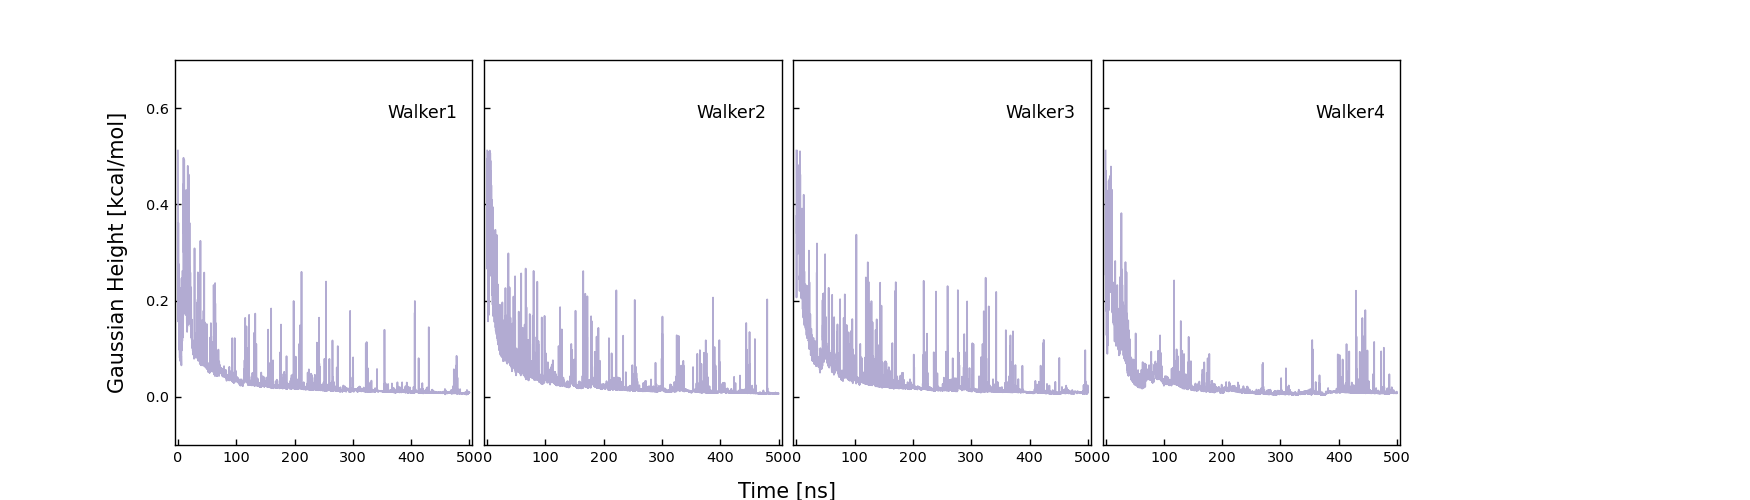

In [26]:
#Plot the Gaussian height as a function of time for a well-tempered Metadynamics simulation##
%matplotlib notebook


#Introduce the dictionaries that will store the CVs.
d_Time={}
d_gh={}

#Give the number of multiple walkers
n_walkers=4

#Loop over the HILLS file for each walker to read the Gaussian Heights
for run in range(0, n_walkers):
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/HILLS/HILLS.{run}", comments="#")[:, 0]/1000
    #Read Gaussian Heights and convert to kcal/mol
    d_gh[f"gh{run}"]=np.loadtxt(f"{path}/HILLS/HILLS.{run}", comments="#")[:, 5]/4.186798


########################################################################

#Plot the CV space that has been sampled during the Funnel MetaD simulation in one figure
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 4))

#Skip every 'step' data
step=50
              
#For Glycine-Archer-Attempt2:
#reset_points=[3.616] 

xmin=float("{0:.1f}".format(np.amin(d_Time[f"Time{1}"])))              
xmax=float("{0:.1f}".format(np.amax(d_Time[f"Time{1}"])))
xstep=100

for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_Time[f"Time{i}"])[::step], np.array(d_gh[f"gh{i}"])[::step], linewidth=1, color=col2['lavender'])
    ax.set_xlim(xmin-5, xmax+5)
    ax.set_xticks(np.arange(xmin, xmax+1, xstep))
    ax.set_xticklabels(np.arange(int(xmin), int(xmax)+1, xstep), fontsize='small')
    ax.set_ylim([-0.1, 0.7])
    ax.set_yticks([0, 0.2, 0.4, 0.6])
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6], fontsize='small')
    ax.text(0.95, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='right')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
#     for item in reset_points:
#         ax.axvline(item, ls='dotted', c='black', lw=1.0)


    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('Gaussian Height [kcal/mol]', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0.04, hspace=0.04)


#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/gaussian_height_all.png", bbox_inches='tight', dpi=600)

plt.show()

### Plot space sampling

In [ ]:
#Plot the space sampling for a Funnel Metadynamics simulation##
%matplotlib notebook


#Introduce the dictionaries that will store the CVs.
d_Time={}
d_lp={}
d_ld={}

#Give the number of multiple walkers
n_walkers=4

# #Define path of simulation data  
for run in range(1, n_walkers+1):
    walker=int(f"{run}")-1
    print("Walker: ", walker)
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 0]/1000
    #Read CVs and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 1]*10
    d_ld[f"ld{run}"]=np.loadtxt(f"{path}/{run}/COLVAR", comments="#")[:, 2]*10


########################################################################

#Plot the CV space that has been sampled during the Funnel MetaD simulation in one figure
fig, axs = plt.subplots(nrows=1, ncols=n_walkers, sharex=True, sharey=True, figsize=(14, 3))

#Define colormap
cmap=plt.cm.Purples
step=100

for i, ax in enumerate(fig.axes):
    sctr=ax.scatter(np.array(d_lp[f"lp{i+1}"])[::step], np.array(d_ld[f"ld{i+1}"])[::step], s=0.3, c=np.array(d_Time[f"Time{i+1}"])[::step], alpha=0.7, cmap='PuOr')
    ax.set_xticks([-5, 0, 5, 10, 15, 20])
    ax.set_xticklabels([-5, 0, 5, 10, 15, 20], fontsize='small')
    ax.set_yticks([0, 5, 10])
    ax.set_yticklabels([0, 5, 10], fontsize='small')
    ax.text(0.5, 0.85, f"Walker{i+1}", transform=ax.transAxes)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Position along funnel axis [$\AA$]', fontsize='large')
plt.ylabel('Distance from funnel axis [$\AA$]', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0, hspace=0)

#Define colorbar parameters
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=plt.colorbar(sctr, cax=cbar_ax)
cbar.set_label("Time [ns]", fontsize='large', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(direction='in', labelsize='small')

#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/cv_space_sampling_all.png", bbox_inches='tight', dpi=600)


plt.show()

Walker:  0
Walker:  1
Walker:  2


## Free Energy profile along the lp

<IPython.core.display.Javascript object>


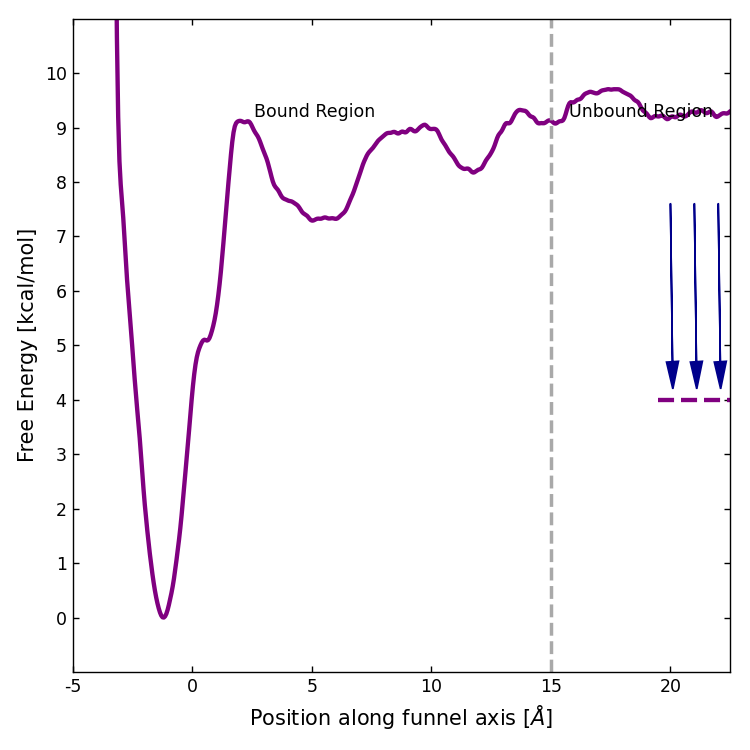

In [28]:
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#
%matplotlib notebook

xdata=np.loadtxt(f"{path}/HILLS/fes-lp.dat")[:, 0]*10
ydata=np.loadtxt(f"{path}/HILLS/fes-lp.dat")[:, 1]/4.186798

# for i, j in zip(xdata, ydata):
#     print(i, j)

fig, ax = plt.subplots(1, figsize=(6, 6))

ax.plot(xdata, ydata, color='purple', linewidth=2.5)
ax.set_xlim([-5, 22.5])
ax.set_xticks(np.arange(-5, 24, 5))
ax.set_xticklabels(np.arange(-5, 24, 5), fontsize='large')
ax.set_ylim([-1, 11])
ax.set_yticks(np.arange(0, 11, 1))
ax.set_yticklabels(np.arange(0, 11, 1), fontsize='large')
ax.set_xlabel('Position along funnel axis [$\AA$]', fontsize='large')
ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax.axvline(x=15, linestyle='--', linewidth=2.0, color='darkgray')
ax.text(0.275, 0.85, "Bound Region", transform=ax.transAxes)
ax.text(0.755, 0.85, "Unbound Region", transform=ax.transAxes)
ax.hlines(y=4, xmin=19.5, xmax=22.55, linewidth=2.5, color=col2['purple'], ls='dashed')
ax.arrow(20, 7.6, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)
ax.arrow(21, 7.6, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)
ax.arrow(22, 7.6, 0.1, -3.4, lw='1.0', color='darkblue', head_width = 0.5, head_length = 0.5, length_includes_head=True)

plt.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig(f"{path}/ANALYSIS/fes.png", bbox_inches='tight', dpi=600)
plt.show()

### Free Energy Profiles of each Walker

<IPython.core.display.Javascript object>


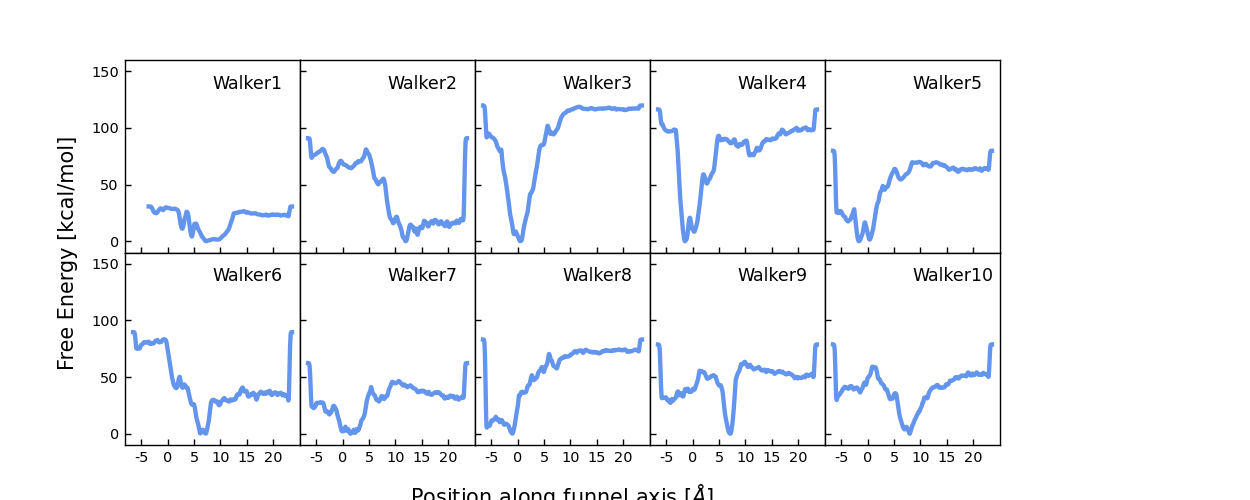

In [66]:
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#
%matplotlib notebook

#Introduce the dictionaries that will store the CV and the FE.
d_lp={}
d_fes={}
n_walkers=8

for run in range(1, n_walkers+1):
    #Read lp and convert to Angstrom
    d_lp[f"lp{run}"]=np.loadtxt(f"{path}/fes-lp-w{run}.dat", comments="#")[:, 0]*10
    #Read free energy and convert to kcal/mol
    d_fes[f"fes{run}"]=np.loadtxt(f"{path}/fes-lp-w{run}.dat", comments="#")[:, 1]/4.186798
    

########################################################################

#Plot the CV space that has been sampled during the Funnel MetaD simulation in one figure
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 4))

# #Define colormap
# cmap=plt.cm.Purples
step=1

for i, ax in enumerate(fig.axes):
    line=ax.plot(np.array(d_lp[f"lp{i+1}"])[::step], np.array(d_fes[f"fes{i+1}"])[::step], color='cornflowerblue', linewidth=2.5)
    ax.set_xticks([-5, 0, 5, 10, 15, 20])
    ax.set_xticklabels([-5, 0, 5, 10, 15, 20], fontsize='small')
    ax.set_ylim([-10, 160])
    ax.set_yticks([0, 50, 100, 150])
    ax.set_yticklabels([0, 50, 100, 150], fontsize='small')
    ax.text(0.5, 0.85, f"Walker{i+1}", transform=ax.transAxes)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Position along funnel axis [$\AA$]', fontsize='large')
plt.ylabel('Free Energy [kcal/mol]', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.8, wspace=0, hspace=0)


#Save figure in the ANALYSIS folder as a .png image
plt.savefig(f"{path}/ANALYSIS/free_energy_all.png", bbox_inches='tight', dpi=600)
plt.show()


### Check FE convergence

<IPython.core.display.Javascript object>


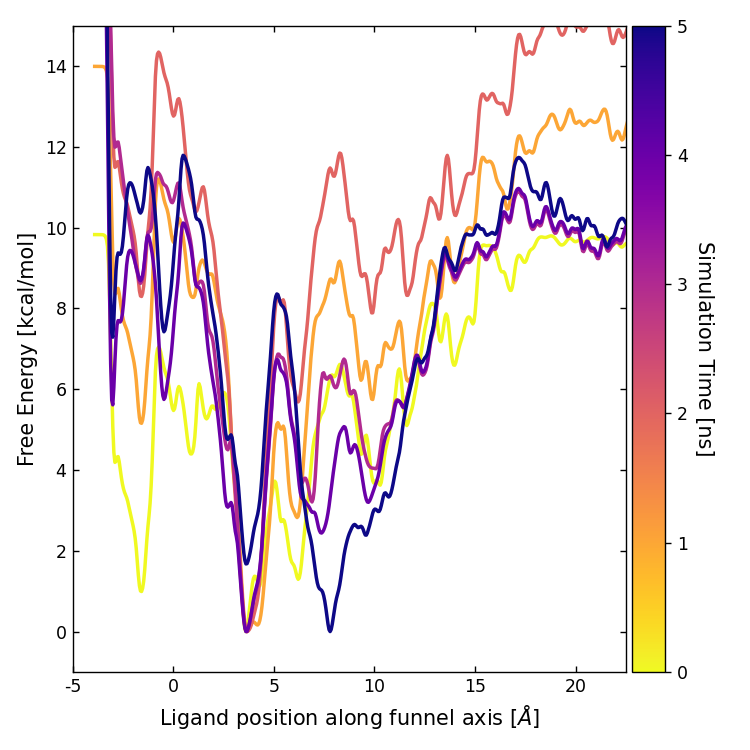

In [9]:
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#
%(ls HILLS.* | wc -l)
xdata=np.loadtxt(f"{path}/HILLS/fes-all.dat", comments="#")[:, 0]*10
ydata=np.loadtxt(f"{path}/HILLS/fes-all.dat", comments="#")[:, 1:]/4.186798

fig, ax = plt.subplots(1, figsize=(6, 6))

# for i in range(15):
#     y=Y_dat[:, i]
#     ax1.plot(X_dat, y, linewidth=1.5)
    #ax1.plot(np.array_split(np.array(X_dat).T, n_segs)[:][0], np.array_split(np.array(Y_dat).T, n_segs)[:][0], np.array_split(np.array(Y_dat).T, n_segs)[:][1])

# your dataset
nValues = np.arange(6)
#xValues = np.linspace(0,10)
dataset = [ydata[:, n] for n in nValues]
stride=1 #nValues.max()*stride=simulation time [ns]

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max()*stride)
#colormap = cm.viridis_r
colormap = cm.plasma_r

# plot
for n in nValues:
    plt.plot(xdata, dataset[n], color=colormap(normalize(n*stride)), lw=2.0)

# setup the colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
#scalarmappaple.set_array(nValues*1)
cbar=plt.colorbar(scalarmappaple, pad=0.01)
cbar.set_label('Simulation Time [ns]', rotation=270, fontsize='large', labelpad=15)
ax.set_xlim([-5, 22.5])
ax.set_xticks(np.arange(-5, 24, 5))
ax.set_xticklabels(np.arange(-5, 24, 5), fontsize='medium')
ax.set_xlabel('Ligand position along funnel axis [$\AA$]', fontsize='large')
ax.set_ylim([-1, 15])
ax.set_yticks(np.arange(0, 15, 2))
ax.set_yticklabels(np.arange(0, 15, 2), fontsize='medium')
ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
#ax1.yaxis.set_label_position("right")
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')

plt.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig(f"{analysis_path}/fes-conv.png", bbox_inches='tight', dpi=600)
plt.show()

8


<IPython.core.display.Javascript object>


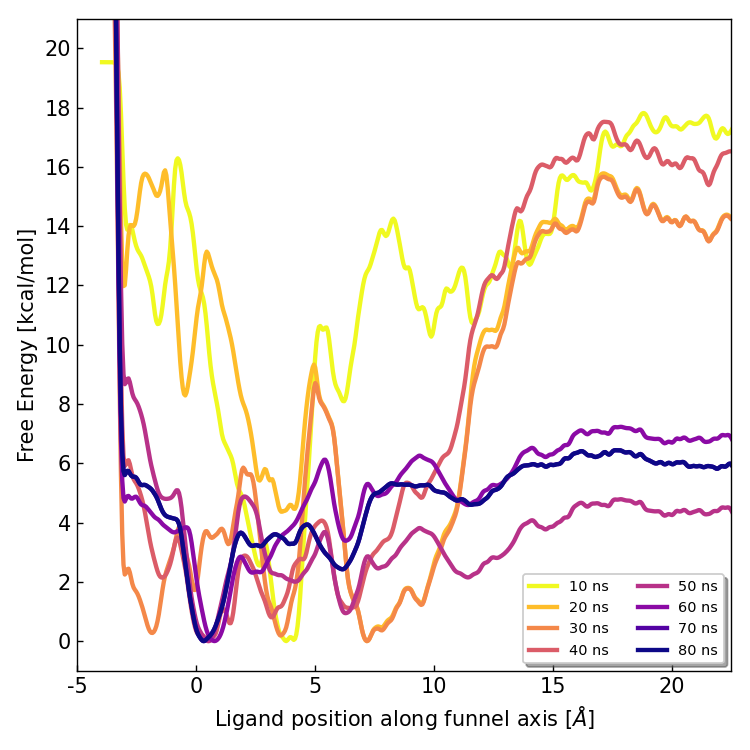

In [93]:
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#

xdata=np.loadtxt(f"{path}/HILLS/HILLS_TEST/fes-all.dat", comments="#")[:, 0]*10
ydata=np.loadtxt(f"{path}/HILLS/HILLS_TEST/fes-all.dat", comments="#")[:, 1:]/4.186798
print(np.array(ydata).shape[1])
fig, ax = plt.subplots(1, figsize=(6, 6))

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.plasma_r(np.linspace(0, 1, np.array(ydata).shape[1]))))

for i in range(0, np.array(ydata).shape[1]):
    line=ax.plot(np.array(xdata), np.array(ydata)[:,i], linewidth=2.5, label=f"{(i+1)*10} ns")
    ax.set_xlim([-5, 22.5])
    ax.set_xticks(np.arange(-5, 24, 5))
    ax.set_xticklabels(np.arange(-5, 24, 5), fontsize='large')
    ax.set_ylim([-1, 21])
    ax.set_yticks(np.arange(0, 21, 2))
    ax.set_yticklabels(np.arange(0, 21, 2), fontsize='large')
    ax.set_xlabel('Ligand position along funnel axis [$\AA$]', fontsize='large')
    ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
    ax.legend(loc=4, ncol=2, fontsize='small', fancybox=True, shadow=True)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

plt.tight_layout() # otherwise the right y-label is slightly clipped
#plt.savefig(f"{path}/ANALYSIS/fes-conv.png", bbox_inches='tight', dpi=600)
plt.show()

### Plot $\Delta$G$_B$ vs Time

31


<IPython.core.display.Javascript object>


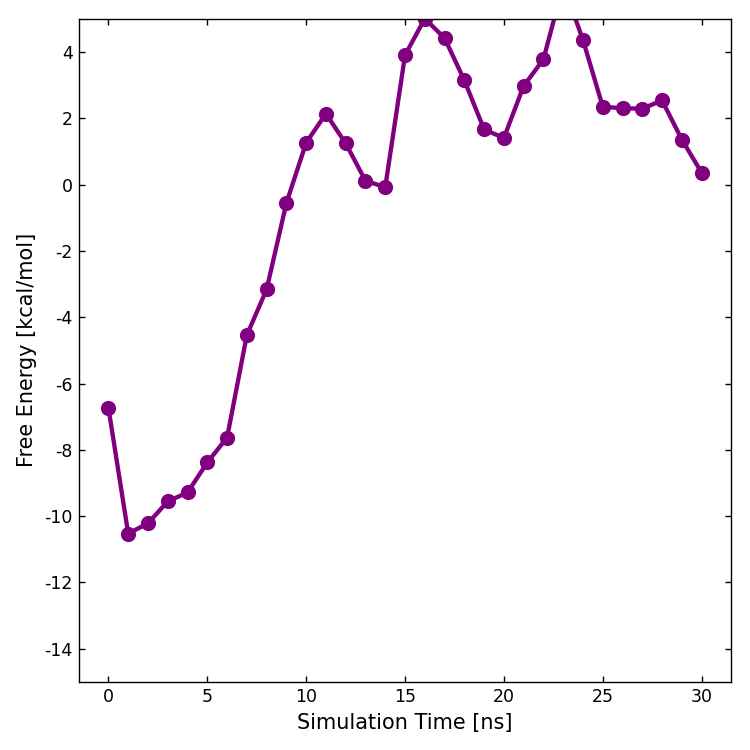

In [35]:
%matplotlib notebook
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#

stride=10
correction=-3.86

xdata=np.loadtxt(f"{path}/HILLS/lp_fes-kcal.dat", comments="#")[:, 0]
ydata=np.loadtxt(f"{path}/HILLS/lp_fes-kcal.dat", comments="#")[:, 1]-correction


xmin=0
xmax=len(xdata)
print(xmax)
ymin=-26
ymax=10

fig, (ax) = plt.subplots(1, figsize=(6, 6))
ax.plot(xdata[::], ydata[::], color='purple', alpha=1.0, lw=2.5)
ax.scatter(xdata[::], ydata[::], color='purple', alpha=1.0, edgecolors='face', marker="o", s=60)
ax.set_ylim(-15, 5)
ax.set_yticks(np.arange(-14, 5, 2))
ax.set_yticklabels(np.arange(-14, 5, 2))
# ax.set_xlim(xmin, xmax)
# ax.set_xticks(np.arange(xmin, xmax+1), stride)
# ax.set_xticklabels(np.arange(xmin, (stride*len(xdata)+1), stride))
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax.set_xlabel('Simulation Time [ns]', fontsize='large')
ax.set_ylabel('Free Energy [kcal/mol]', fontsize='large')
#ax.text(0.8, 1.42, "Glycine", transform=ax.transAxes, fontsize='large')

fig.tight_layout()

plt.savefig(f"{path}/ANALYSIS/deltag.png", bbox_inches='tight', dpi=600)
plt.show()

### Free Energy heatmap

<IPython.core.display.Javascript object>


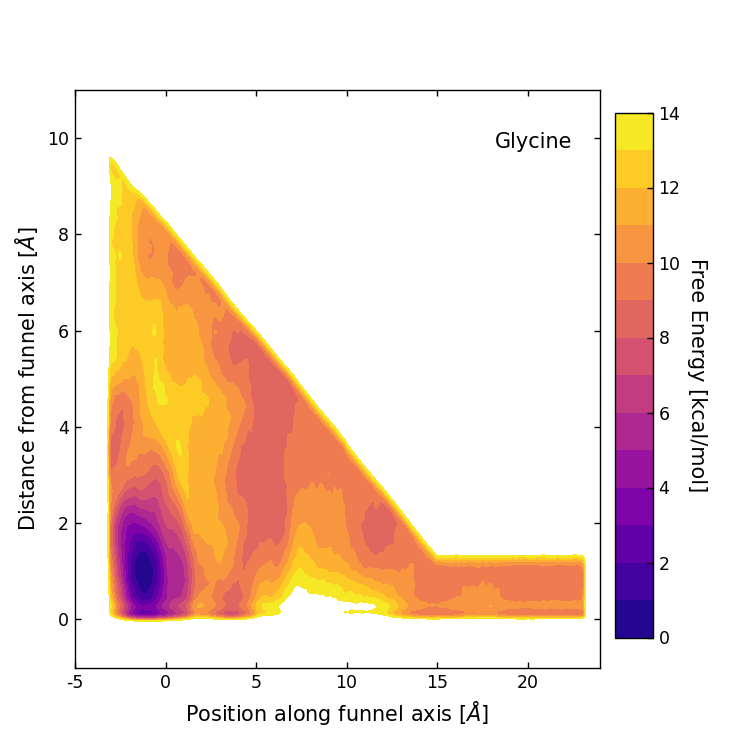

In [38]:
#Plot the Free Energy Surface as a function of the collective variables p, d for a Funnel Metadynamics simulation#
%matplotlib notebook


Z_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 2]/4.186798
X_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 0]*10
Y_dat=np.loadtxt(f"{path}/HILLS/fes.dat")[:, 1]*10


# Convert from pandas dataframes to numpy arrays
X, Y, Z, = np.array([]), np.array([]), np.array([])
for i in range(len(X_dat)):
        X = np.append(X, X_dat[i])
        Y = np.append(Y, Y_dat[i])
        Z = np.append(Z, Z_dat[i])

# create x-y points to be used in heatmap
xi = np.linspace(X.min(), X.max(), 1000)
yi = np.linspace(Y.min(), Y.max(), 1000)

# Z is a matrix of x-y values
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

# I control the range of my colorbar by removing data 
# outside of my range of interest
zmin = 0
#zmax = int(Z_dat[0])
zmax = 15
zi[(zi<zmin) | (zi>zmax)] = None
zstep=1.0
levels = np.arange(zmin, zmax, zstep)
props=dict(facecolor='white', edgecolor='white', boxstyle='round')

fig, ax=plt.subplots(1, figsize=(6, 6))

# Create the contour plot
contourplot = plt.contourf(xi, yi, zi, 15, cmap=plt.cm.plasma,
                  levels=levels)

ax.set_xticks([-5, 0, 5, 10, 15, 20])
ax.set_xticklabels([-5, 0, 5, 10, 15, 20])
ax.set_ylim(-1, 11)
ax.set_yticks(np.arange(0, 11, 2))
ax.set_yticklabels(np.arange(0, 11, 2))
ax.set_xlabel('Position along funnel axis [$\AA$]', fontsize='large')
ax.set_ylabel('Distance from funnel axis [$\AA$]', fontsize='large')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax.text(0.8, 0.9, "Glycine", transform=ax.transAxes, fontsize='large', bbox=props)
#ax.text(22, 14, "Glycine", fontsize='large', bbox=props, ha='right')

fig.subplots_adjust(left=0.1, right=0.8, wspace=0, hspace=0)

#Define colorbar parameters
cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
cbar=plt.colorbar(contourplot, cax=cbar_ax)
cbar.set_label("Free Energy [kcal/mol]", fontsize='large', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(direction='in', labelsize='medium')

#plt.tight_layout() # otherwise the right y-label is slightly clipped
plt.savefig(f"{path}/ANALYSIS/fes-heatmap.png", bbox_inches='tight', dpi=600)

plt.show()

### Transfer trajectory files

In [50]:
%cd {path}
!rsync bioc1550@axon:/home/bioc1550/GlyR/FUNNEL_METAD/TWOSUBUNITS/RUN{run}/traj_comp.xtc .
!rsync bioc1550@axon:/home/bioc1550/GlyR/FUNNEL_METAD/TWOSUBUNITS/RUN{run}/conf.gro .
#!rsync bioc1550@axon:/home/bioc1550/GlyR/FUNNEL_METAD/TWOSUBUNITS/RUN{run}/* .
#!rsync bioc1550@axon:/home/bioc1550/GlyR/FUNNEL_METAD/VDW_SPHERE/RUN1/* .
!echo "Trajectory files for run{run} are now transfered"

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/PROTEIN_LIGAND/TWOSUBUNITS_LIGAND/RUN19
Trajectory files for run19 are now transfered


### Calculate and plot the RMSF of Loop C residues

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD1


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD2


  0%|          | 0/100000 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD3


  0%|          | 0/100000 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD4


  0%|          | 0/100000 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD5


  0%|          | 0/100000 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD6


  0%|          | 0/100000 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD7


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD8


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD9


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD10


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD11


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD12


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD13


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD14


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD15


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD16


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD17


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD18


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD19


  0%|          | 0/100001 [00:00<?, ?it/s]

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD20


  0%|          | 0/100001 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


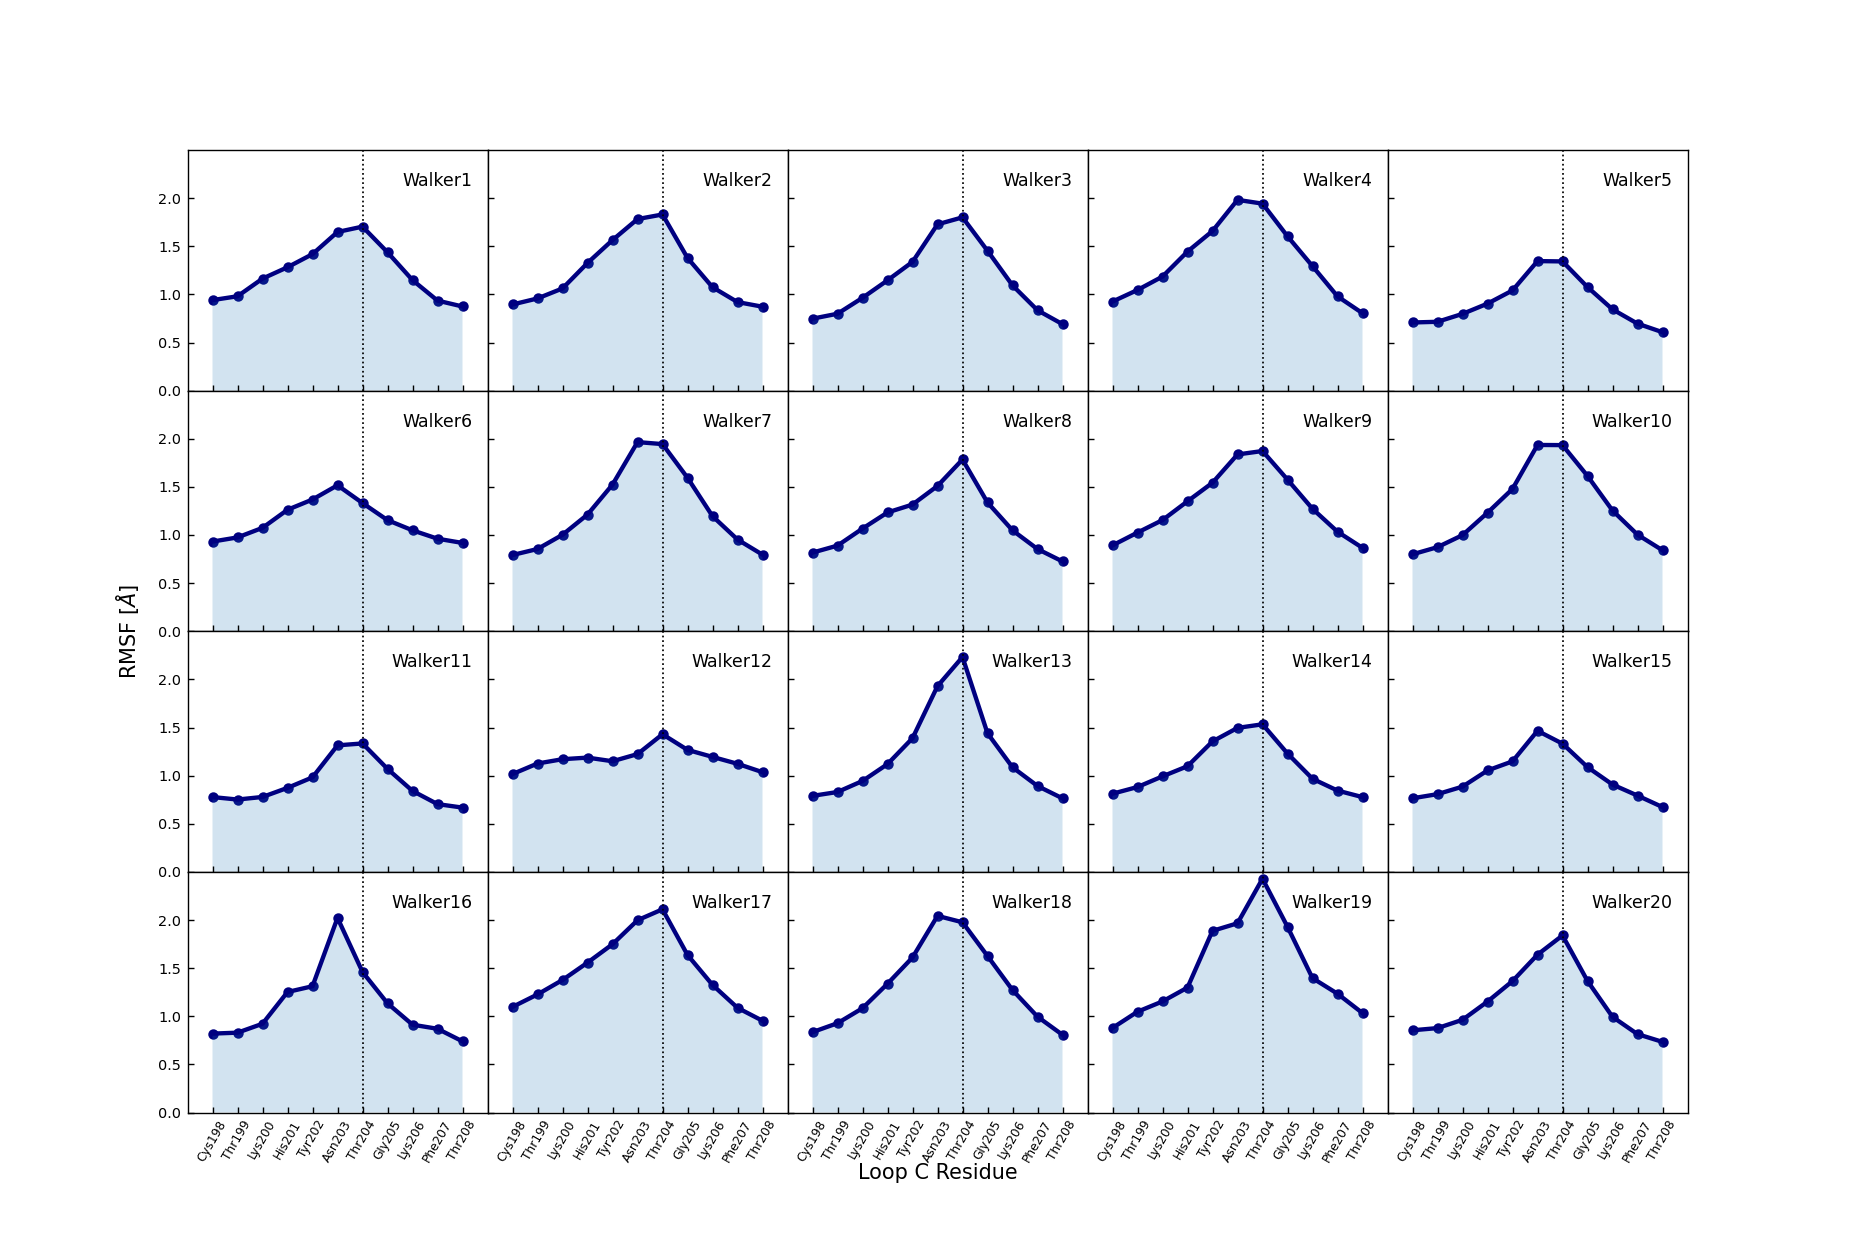

In [7]:
#Plot the Free Energy profile as a function of the collective variable for a WT Metadynamics simulation#
%matplotlib notebook
from MDAnalysis.analysis.rms import RMSF

#Introduce the dictionaries that will store the CV and the FE.
d_resid={}
d_rmsf={}
n_walkers=20

#Loop over the MWs simulations and calculate the principal loop C residues' RMSF values
for run in range(1, n_walkers+1):
    path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/Gly_FMD{run}"
    %cd {path}
    u=mda.Universe("confout.gro", "traj_comp.xtc")
    rmsf=[]
    time=[]
    loopC=u.select_atoms("resid 198-208 and name CA and bynum 0-3406")
    rmsfer = RMSF(loopC, verbose=True).run()
    d_resid[f"resid{run}"]=loopC.resnums
    #Read free energy and convert to kcal/mol
    d_rmsf[f"rmsf{run}"]=rmsfer.rmsf
    

###################################################################################################################

#Plot the RMSF of the amino acids that form loop C of the principal subunit
fig, axs = plt.subplots(nrows=4, ncols=5, sharex=True, sharey=True, figsize=(12, 8))

res=("Cys198", "Thr199", "Lys200", "His201", "Tyr202", "Asn203", "Thr204", "Gly205", "Lys206", "Phe207", "Thr208")

for i, ax in enumerate(fig.axes):
    sctr=ax.scatter(np.array(d_resid[f"resid{i+1}"]), np.array(d_rmsf[f"rmsf{i+1}"]), color='navy', marker='o', s=25)
    line=ax.plot(np.array(d_resid[f"resid{i+1}"]), np.array(d_rmsf[f"rmsf{i+1}"]), color='navy', linewidth=2.5)
    ax.fill_between(np.array(d_resid[f"resid{i+1}"]), 0, np.array(d_rmsf[f"rmsf{i+1}"]), alpha=0.2)
    ax.set_xlim(min(loopC.resnums)-1, max(loopC.resnums)+1)
    ax.set_xticks(np.arange(min(loopC.resnums), max(loopC.resnums)+1))
    ax.set_xticklabels(res, fontsize='7', rotation=60)
    ax.set_ylim(0, 2.5)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    ax.set_yticklabels([0.0, 0.5, 1.0, 1.5, 2.0], fontsize='small')
    ax.text(0.95, 0.85, f"Walker{i+1}", transform=ax.transAxes, ha='right')
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')
    ax.axvline(204, ls='dotted', c='black', lw=1.0)
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Loop C Residue', fontsize='large', labelpad=12)
plt.ylabel('RMSF [$\AA$]', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.1, right=0.9, wspace=0, hspace=0)

#Save figure in the ANALYSIS folder as a .png image
#plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/AXON/ANALYSIS/loopC_RMSF_all20.png", bbox_inches='tight', dpi=600)
plt.show()

### Calculate and plot loop C opening

The opening of loop C is monitored by measuring the distance between the Thr204 and the Arg65 C$\alpha$ atoms, which are located on loop C and $\beta$2 $\beta$ sheet, respectively.

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly7


<IPython.core.display.Javascript object>


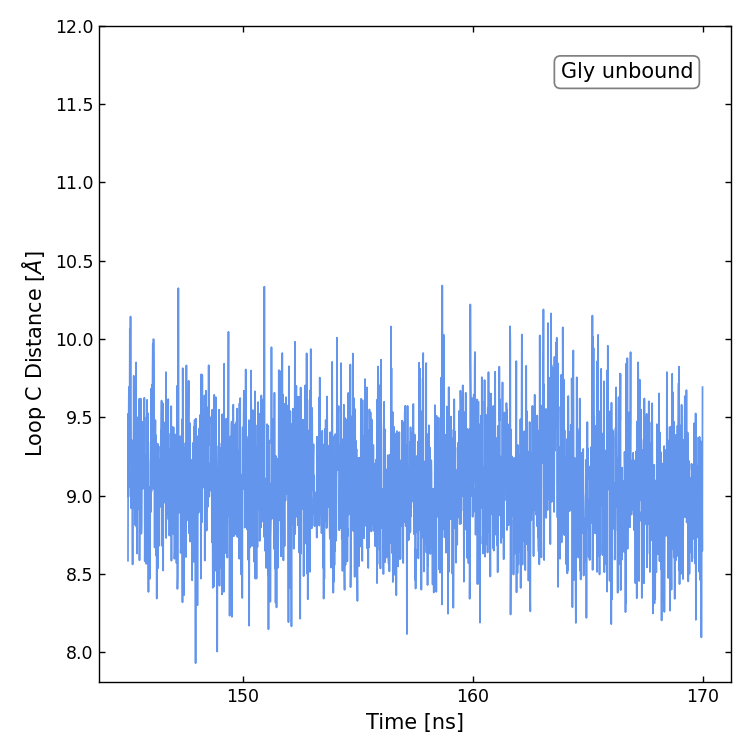

In [15]:
from MDAnalysis.analysis.distances import dist

run="7"
path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly{run}"
%cd {path}
u=mda.Universe("conf.gro", "traj_comp.xtc")
distance=[]
time=[]
loopC=u.select_atoms(f"resid 204 and name CA and bynum 0-3406")
bsheet=u.select_atoms("resid 65 and name CA and bynum 3407-6813")

#Select a time window during which the ligand remains either bound or unbound
start, stop=14500, 17000

for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time=np.array(time)
dist=np.array(distance)[:, 2]

           
#leg="Gly bound"
leg="Gly unbound"
color_dict={'bound':'indianred', 'unbound':'cornflowerblue'}
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
                       
fig, (ax1) = plt.subplots(1,figsize=(6,6))


ax1.plot(time, dist, color=color_dict['unbound'], linewidth=1.0)
# ax1.set_xticks([250, 260, 270, 280, 290, 300])
# ax1.set_xticklabels([250, 260, 270, 280, 290, 300])
ax1.set_xticks([150, 160, 170])
ax1.set_xticklabels([150, 160, 170])
ax1.set_yticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_yticklabels([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax1.set_xlabel('Time [ns]', fontsize='large')
ax1.set_ylabel('Loop C Distance [$\AA$]', fontsize='large')
#ax1.legend(leg, loc=2,  fancybox=True, shadow=True, fontsize='large')
ax1.text(0.73, 0.92, f"{leg}", transform=ax1.transAxes, fontsize='large', bbox=props)

fig.tight_layout()

#plt.savefig(f"{path}/loopC{run}_bound.png", bbox_inches='tight', dpi=600)
plt.savefig(f"{path}/loopC{run}_unbound.png", bbox_inches='tight', dpi=600)


### Plot Loop C distribution

The distribution of loop C opening, as was computed previously, is plotted. The previous cell needs to run first, as the calculation is performed there.

<IPython.core.display.Javascript object>


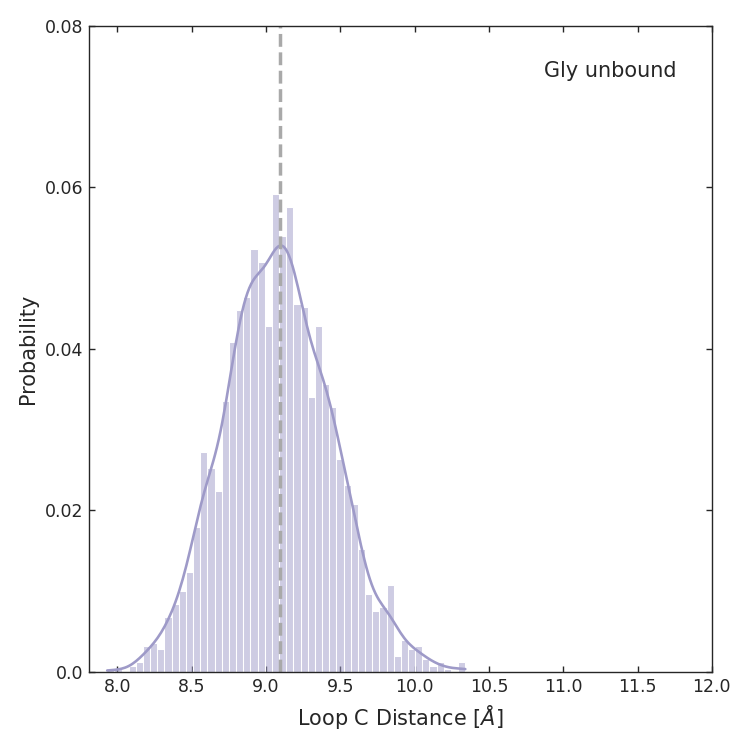

In [69]:
%matplotlib notebook

import seaborn as sns
# leg="Gly bound"
leg="Gly unbound"

color_dict={'bound':'flare', 'unbound':'blues'}
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
nbins=50    
# hist=np.histogram(dist, bins=nbins)
     
fig, (ax1) = plt.subplots(1,figsize=(6,6))
# print(dist.shape[0])
#sns.set_style('white')
hist=sns.histplot(dist, hue=None, palette='Purples', kde=True, bins=nbins, legend=False, stat='probability')
#ax1.hist(dist, bins=nbins, histtype='bar', align='mid', orientation='vertical', color=color_dict['unbound'], density=True, alpha=0.7)
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_xticklabels([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_yticks([0.0, 0.02, 0.04, 0.06, 0.08])
ax1.set_yticklabels([0.0, 0.02, 0.04, 0.06, 0.08])
ax1.tick_params(axis='both', bottom=True, top=True, right=True, left=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax1.set_xlabel('Loop C Distance [$\AA$]', fontsize='large')
ax1.set_ylabel('Probability', fontsize='large')
ax1.text(0.73, 0.92, f"{leg}", transform=ax1.transAxes, fontsize='large', bbox=props)
# ax1.axvline(x=9.16, linestyle='--', linewidth=2.5, color=color_dict['bound'])
ax1.axvline(x=9.094, linestyle='--', linewidth=2.0, color='darkgray')

fig.tight_layout()

# #plt.savefig(f"{path}/loopCdistr{run}_bound.png", bbox_inches='tight', dpi=600)
plt.savefig(f"{path}/loopCdistr{run}_unbound.png", bbox_inches='tight', dpi=600)
plt.show()

/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly5
       distance  Glycine
0      8.517244    Bound
1     10.024378    Bound
2     10.023280    Bound
3      9.524253    Bound
4      9.917001    Bound
...         ...      ...
2495   9.231697  Unbound
2496   9.269269  Unbound
2497   9.623934  Unbound
2498   9.479206  Unbound
2499  10.074471  Unbound

[5000 rows x 2 columns]


<IPython.core.display.Javascript object>


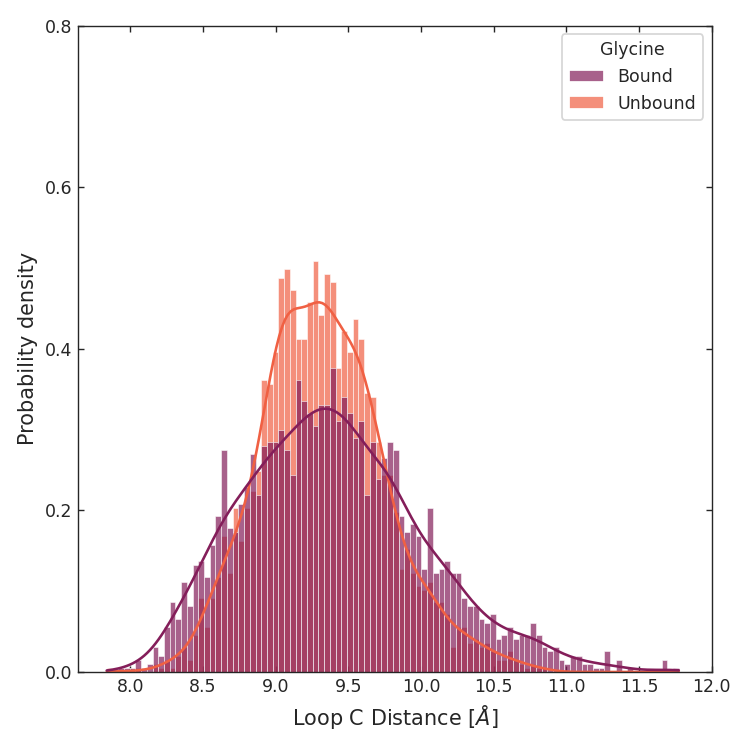

In [95]:
%matplotlib notebook

import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.distances import dist

#Compute loop C opening
run="5"
path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly{run}"
%cd {path}
u=mda.Universe("conf.gro", "traj_comp.xtc")
loopC=u.select_atoms(f"resid 204 and name CA and bynum 0-3406")
bsheet=u.select_atoms("resid 65 and name CA and bynum 3407-6813")

#Select a time window during which the ligand remains bound 
start, stop=27500, 30000
distance=[]
time=[]
for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time_bound=np.array(time)
dist_bound=np.array(distance)[:, 2]

#Select a time window during which the ligand remains unbound
start, stop=2500, 5000
distance=[]
time=[]
for ts in u.trajectory[start:stop]:
    distance.append((mda.analysis.distances.dist(loopC, bsheet, offset=0, box=None)))
    time.append((ts.time/1000))

time_unbound=np.array(time)
dist_unbound=np.array(distance)[:, 2]

################################

df_a = pd.DataFrame(data = dist_bound, columns=['distance']).assign(Glycine = 'Bound')
df_b = pd.DataFrame(data = dist_unbound, columns=['distance']).assign(Glycine = 'Unbound')

dist = pd.concat([df_a, df_b])
print(dist)


props = dict(boxstyle='round', facecolor='white', alpha=0.5)
nbins=100    

     
fig, (ax1) = plt.subplots(1,figsize=(6,6))

hist=sns.histplot(data=dist, x='distance', hue='Glycine', palette='rocket', kde=True, bins=nbins, legend=True, stat='density', alpha=0.7)
ax1.set_xticks([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_xticklabels([8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0])
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8])
ax1.tick_params(axis='both', bottom=True, top=True, right=True, left=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize='medium')
ax1.set_xlabel('Loop C Distance [$\AA$]', fontsize='large')
ax1.set_ylabel('Probability density', fontsize='large')
# ax1.axvline(x=9.16, linestyle='--', linewidth=2.5, color=color_dict['bound'])
#ax1.axvline(x=9.094, linestyle='--', linewidth=2.0, color='darkgray')

fig.tight_layout()

plt.savefig(f"{path}/loopCdistr{run}.png", bbox_inches='tight', dpi=600)
plt.show()

### Plot binding loop C movement

[0.0000e+00 1.0000e-02 2.0000e-02 ... 3.7842e+02 3.7843e+02 3.7844e+02] [[13.29896871]
 [13.2882065 ]
 [13.54982375]
 ...
 [15.34974702]
 [16.22718193]
 [16.46779511]]


<IPython.core.display.Javascript object>


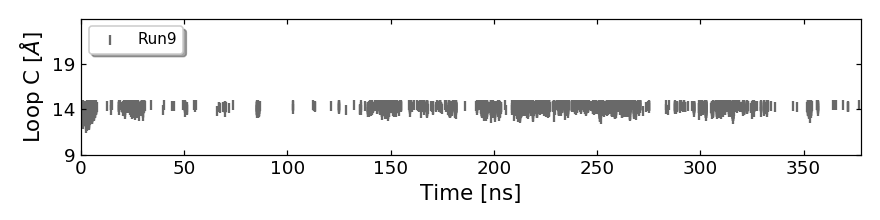

In [616]:
# time=np.array(time)
# dist=np.array(distance)[:, 2]
print(time, dist)

bound=[]
for x, y in zip(time, dist):
    if y<=14.5:
        bound.append((x, y))
        
        
        
# time=np.array(time)
# dist=np.array(distance)[:, 2]
# print(time, dist)

xmin=float("{0:.0f}".format(np.amin(time)))              
xmax=float("{0:.0f}".format(np.amax(time)))
ymin=float("{0:.2f}".format(np.amin(dist)))
ymax=float("{0:.2f}".format(np.amax(dist)))            
leg=[f"Run{run}"]
# print(f"x-axis minimum and maximum is {xmin} and {xmax}")
# print(f"y-axis minimum and maximum is {ymin} and {ymax}")
              
              
fig, (ax1) = plt.subplots(1,figsize=(8,2))

ax1.scatter(np.array(bound)[:,0], np.array(bound)[:,1], color='dimgrey', marker='|')
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([int(ymin)-1, int(ymax)+1])
ax1.xaxis.set_ticks(np.arange(int(xmin), int(xmax), 50))
ax1.yaxis.set_ticks(np.arange(int(ymin)-2, int(ymax)+1, 5))
ax1.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize=small_font)
ax1.set_xlabel('Time [ns]', fontsize=large_font)
ax1.set_ylabel('Loop C [$\AA$]', fontsize=large_font)
ax1.legend(leg, loc=2,  fancybox=True, shadow=True)
ax1.set_title=("Loop C bound")
fig.tight_layout()

plt.savefig(f"{path}/loopCbind{run}.png", bbox_inches='tight', dpi=600)
# plt.show()

### Calculate the orientation of Glu157 with time

37845


<IPython.core.display.Javascript object>


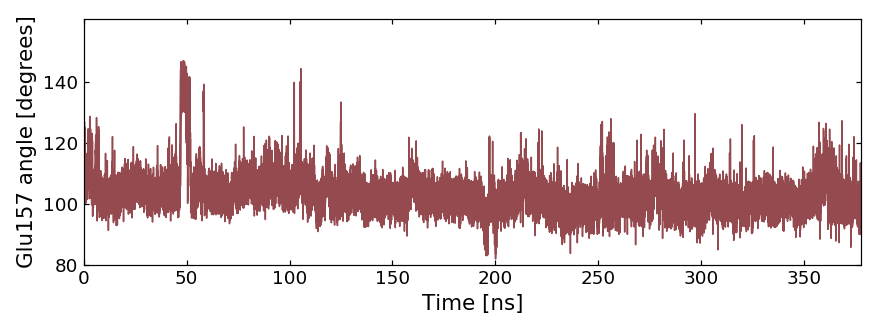

In [617]:
#Creat atom groups for the Glu157 atoms that form the vector
ca=u.select_atoms("resid 157 and name CA and bynum 0-3406")
cd=u.select_atoms("resid 157 and name CD and bynum 0-3406")

#Reference vector is the unit vector 
r0=np.array([0,0,1])
r0=r0.reshape(1,3)

def dotproduct(v1, v2):
    for a, b in zip(v1,v2):
        return sum(a*b)
# print(dotproduct(r0, r))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
  return math.degrees(math.acos(dotproduct(v1, v2) / (length(v1) * length(v2))))

print(len(u.trajectory))

data=[]
for ts in u.trajectory:
    ra=ca.positions
    rd=cd.positions
    r=rd-ra
    r=r.reshape(1,3)
    data.append((ts.time/1000, angle(r0, r)))
       
data=np.array(data)    

#Plot Glu157 orientation with time
xmin=float("{0:.0f}".format(np.amin(data[:,0])))              
xmax=float("{0:.0f}".format(np.amax(data[:,0])))
# ymin=float("{0:.1f}".format(np.amin(data[:,1])))
# ymax=float("{0:.1f}".format(np.amax(data[:,1]))) 
ymin=80
ymax=160
leg=[f"Run{run}"]
# print(f"x-axis minimum and maximum is {xmin} and {xmax}")
# print(f"y-axis minimum and maximum is {ymin} and {ymax}")
              
              
fig, (ax1) = plt.subplots(1,figsize=(8,3))

#ax1.scatter(np.array(data)[:,0], np.array(data)[:,1], color='darkorchid', marker='o', s=5)
ax1.plot(np.array(data)[:,0], np.array(data)[:,1], color=col1['red'], linewidth=1.0)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([int(ymin), int(ymax)+1])
ax1.xaxis.set_ticks(np.arange(int(xmin), int(xmax), 50))
ax1.yaxis.set_ticks(np.arange(int(ymin), int(ymax), 20))
ax1.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize=small_font)
ax1.set_xlabel('Time [ns]', fontsize=large_font)
ax1.set_ylabel('Glu157 angle [degrees]', fontsize=large_font)
#ax1.legend(leg, loc=2,  fancybox=True, shadow=True)
#ax1.set_title=("Loop C bound")
fig.tight_layout()

plt.savefig(f"{path}/glu157angle{run}.png", bbox_inches='tight', dpi=600)

### Draw colorbar for VMD images

In [ ]:
%matplotlib notebook
I_old = np.array(np.arange(200, 251))
I_new=np.reshape(I_old, (-1, 51))

fig, ax = plt.subplots()

im = ax.imshow(I_new, cmap=plt.cm.bwr_r)

#fig.colorbar(im, ax=ax)
#legend
cbar = fig.colorbar(im, ax=ax)

# cbar.ax.get_yaxis().set_ticks([])
# for j, lab in enumerate(['$0$','$1$','$2$','$>3$']):
#     cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Time [ns]', rotation=270, fontsize=14)


plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly2/colorbar.png", bbox_inches='tight', dpi=600)
plt.show()

### Gly-Thr204 HB


Compute and plot the Hydrogen Bond formation between the ligand Gly and Thr204.

In [72]:
# Import the MDAnalysis built-in tool for HB Analysis
import MDAnalysis
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

path="/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly1"
# Define the protein universe
# Note that when using this tool, it is recommended to include the .tpr file instead of the .gro file,
# because it contains bond information, required for the identification of donors and acceptors.
protein = MDAnalysis.Universe(f"{path}/topol.tpr", f"{path}/traj_comp.xtc")
GLX=protein.select_atoms('resname GLX and name O OXT')
THR=protein.select_atoms('resname THR and name HG1 and bynum 3129')
print(GLX.resnames, THR.names, THR.indices)

#print(len(protein.trajectory))
#Define the atom selections for the HB calculation.
#In this case, the THR hydrogens and the GLX oxygens, which act as the HB acceptors are specifically defined.
hbonds = HBA(universe=protein, hydrogens_sel='resname THR and name HG1 and bynum 3129', acceptors_sel='resname GLX and name O OXT')

print(hbonds)
# Perform the HB calculation
hbonds.run(start=0, stop=len(protein.trajectory), step=1)
    
# Plot the total number of GLX-THR HBs vs time
hbonds_time=hbonds.times
hbonds_data=hbonds.count_by_time()
print(hbonds_time)
# pyplot.plot(hbonds_time, hbonds_data, color='darkorange')
# pyplot.title("GLX-THR Hydrogen Bonds")
# pyplot.xlabel("Time [ps]")
# pyplot.ylabel("# Hydrogen Bonds")
# pyplot.show()

fig, (ax) = plt.subplots(1,figsize=(4,4))

ax.plot(hbonds_time, hbonds_data, color='cornflowerblue')
ax.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize=small_font)
#ax.set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000])
ax.set_xticklabels([0, 50, 100, 150, 200, 250, 300], fontsize='small')
ax.set_xlabel("Time [ns]", fontsize='large')
ax.set_yticks([0, 1])
ax.set_yticklabels([0, 1], fontsize='small')
ax.set_ylabel("# Hydrogen Bonds", fontsize='large')

fig.tight_layout()

plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/ANALYSIS/glx_thr204_hbs_1.png", bbox_inches='tight', dpi=600)
plt.show()

# Compute and print the average number of HBs and the standard deviation
# aver_hbonds=round(np.mean(hbonds_data), 2)
# std_hbonds=round(np.std(hbonds_data), 2)
# print(f"The average number of GLX-THR HBs is {aver_hbonds} ± {std_hbonds}")

['GLX' 'GLX' 'GLX' 'GLX' 'GLX' 'GLX' 'GLX' 'GLX' 'GLX' 'GLX'] ['HG1'] [3128]


KeyboardInterrupt: 

### Plot Gly-Thr204 HB formation

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


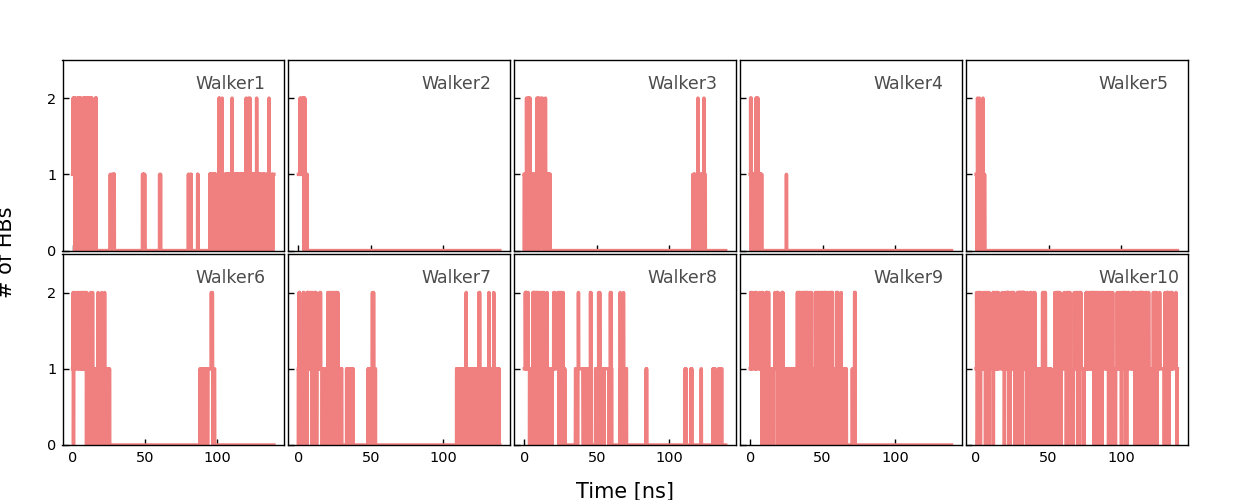

In [7]:
%matplotlib notebook

#Introduce the dictionaries that will store the CVs.
d_Time={}
d_hb={}


# #Define path of simulation data  
for run in range(1, 11):
    repeat=int(f"{run}")-1
    print(repeat)
    #path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/Gly{run}"
    path=f"/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/TAURINE/ARCHER/Tau{run}"
    #Read time and convert to ns
    d_Time[f"Time{run}"]=np.loadtxt(f"{path}/hbnum.xvg", comments=("#", "@"))[:, 0]
    #Read number of HBs
    d_hb[f"hb{run}"]=np.loadtxt(f"{path}/hbnum.xvg", comments=("#", "@"))[:, 1]
    

########################################################################

#Plot the CV space that has been sampled during the Funnel MetaD simulation in one figure
fig, axs = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 4))

# #Define colormap
# cmap=plt.cm.Purples
step=1

for i, ax in enumerate(fig.axes):
    ax.plot(np.array(d_Time[f"Time{i+1}"])[::step], np.array(d_hb[f"hb{i+1}"])[::step], color='lightcoral', linewidth=2)
#     ax.set_xticks([0, 50000, 100000, 150000, 200000, 250000, 300000])
#     ax.set_xticklabels([0, 50, 100, 150, 200, 250, 300], fontsize='small')
    ax.set_xticks([0, 50000, 100000])
    ax.set_xticklabels([0, 50, 100], fontsize='small')
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([0, 1, 2], fontsize='small')
    ax.text(0.6, 0.85, f"Walker{i+1}", transform=ax.transAxes, alpha=0.7)
    ax.tick_params(axis='both', bottom=True, top=False, which='major', labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction='in')

    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Time [ns]', fontsize='large')
plt.ylabel('# of HBs', fontsize='large')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.02, hspace=0.02)

# #Define colorbar parameters
# cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
# cbar=plt.colorbar(sctr, cax=cbar_ax)
# cbar.set_label("Time/ns", fontsize='large', rotation=270)
# cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.tick_params(direction='in', labelsize='small')

#Save figure in the ANALYSIS folder as a .png image
#plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/GLYCINE/ARCHER/ANALYSIS/glx_thr204_hb_all.png", bbox_inches='tight', dpi=600)
plt.savefig("/biggin/b134/bioc1550/Documents/WORK/GlyR/FUNNEL_METAD/TAURINE/ARCHER/ANALYSIS/tau_thr204_hb_all.png", bbox_inches='tight', dpi=600)
plt.show()

### Older calculations  and plots

Below are some calculations that I have now replaced/improved. Kept for future reference.

In [ ]:
#Plot the CV space that has been sampled during the Funnel MetaD simulation#
%matplotlib notebook

#Read time and convert to ns
Time=np.loadtxt(f"{path}/COLVAR.{repeat}", comments="#")[:, 0]/1000
#Read CVs and convert to Angstrom
lp=np.loadtxt(f"{path}/COLVAR.{repeat}", comments="#")[:, 1]*10
ld=np.loadtxt(f"{path}/COLVAR.{repeat}", comments="#")[:, 2]*10

#Get axes limits
xmin=float("{0:.0f}".format(np.amin(Time)))              
xmax=float("{0:.0f}".format(np.amax(Time)))
xstep=100
y1min=float("{0:.1f}".format(np.amin(lp)))
y1max=float("{0:.1f}".format(np.amax(lp))) 
y1step=10
y2min=float("{0:.1f}".format(np.amin(ld)))
y2max=float("{0:.1f}".format(np.amax(ld))) 
y2step=5
print(f"x-axis minimum is {xmin} and maximum is {xmax}")
print(f"y1-axis minimum is {y1min} and maximum is {y1max}")
print(f"y2-axis minimum is {y2min} and maximum is  {y2max}")   

#Get legend
leg=[f"Run{run}"]

#Define font sizes
large_font=14
small_font=12
          
              
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,3))
ax1.plot(Time, lp, color=col1['yellow'], linewidth=1.0)
ax2.plot(Time, ld, color=col1['red'], linewidth=1.0)
ax1.set_xlim([xmin, xmax])
ax2.set_xlim([xmin, xmax])
ax1.set_ylim([y1min-1, y1max+1])
ax2.set_ylim([y2min-1, y2max+1])
#ax1.xaxis.set_ticks(np.arange(xmin, xmax+1, xstep))
ax2.xaxis.set_ticks(np.arange(xmin, xmax+1, xstep))
#ax1.yaxis.set_ticks(np.arange(int(y1min-1), int(y1max)+2, y1step))
ax2.yaxis.set_ticks(np.arange(int(y2min), int(y2max)+2, y2step))
#ax1.axes.get_xaxis().set_visible(False)
ax2.set_xlabel('Time [ns]', fontsize=large_font)
ax1.set_ylabel('p [$\AA$]', fontsize=large_font)
ax2.set_ylabel('d [$\AA$]', fontsize=large_font)
ax1.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=False, labeltop=False, direction='in', labelsize=small_font)
ax2.tick_params(axis='both', bottom=True, top=True, right=True, which='major', labelbottom=True, labeltop=False, direction='in', labelsize=small_font)

ax1.axhspan(-4.0, 3.0, facecolor=col1['yellow'], alpha=0.3)
ax2.axhspan(0.0, 4.0, facecolor=col1['red'], alpha=0.3)
#ax1.legend(leg, loc=1,  fancybox=True, shadow=True)
#ax2.legend(leg, loc=1,  fancybox=True, shadow=True)


fig.subplots_adjust(wspace=0, hspace=0)

fig.tight_layout()

plt.savefig(f"{path}/pd{run}.png", bbox_inches='tight', dpi=600)
plt.show()